In [3]:
import yfinance as yf
import pandas as pd
import numpy as np 
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error
from pmdarima import auto_arima
import statsmodels.api as sm
import seaborn as sns
import math
import getFamaFrenchFactors as gff
import itertools 
import requests
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.dates as mdates

In [4]:
# periodo di analisi dei prezzi
start = dt.datetime(2014, 5, 31)
end = dt.datetime(2024, 5, 31)


# tickers dei titoli per recuperare i dati
tickers = ["NVDA", "AAPL", "TSLA", "F", "JPM", "BAC"]
# scarico i dati e ritorno la tabella Close aggiustata
data = yf.download(tickers, start = start, end = end, auto_adjust=True)["Close"]

# riordino sulla base della lista tickers 
data = data[tickers]

# pulizia dataframe 
data = data.dropna()

# stampo le prime 10 righe 
data.head(10)


[*********************100%***********************]  6 of 6 completed


Ticker,NVDA,AAPL,TSLA,F,JPM,BAC
Date,,,,,,
2014-06-02,0.450631,19.766951,13.646667,9.208930,40.952995,12.230072
2014-06-03,0.448728,20.046482,13.662667,9.270545,41.137970,12.190000
2014-06-04,0.449204,20.275393,13.599333,9.404984,41.197159,12.190000
2014-06-05,0.451107,20.354944,13.793333,9.343368,41.900066,12.366320
2014-06-06,0.452773,20.298975,13.878000,9.567428,42.151623,12.494548
2014-06-09,0.453249,20.623789,13.687333,9.522614,42.484577,12.694910
2014-06-10,0.455628,20.744841,13.486667,9.528217,42.839718,12.759027
2014-06-11,0.461576,20.659002,13.631333,9.466599,42.373592,12.494548
2014-06-12,0.464431,20.313437,13.568000,9.253740,42.203415,12.358305


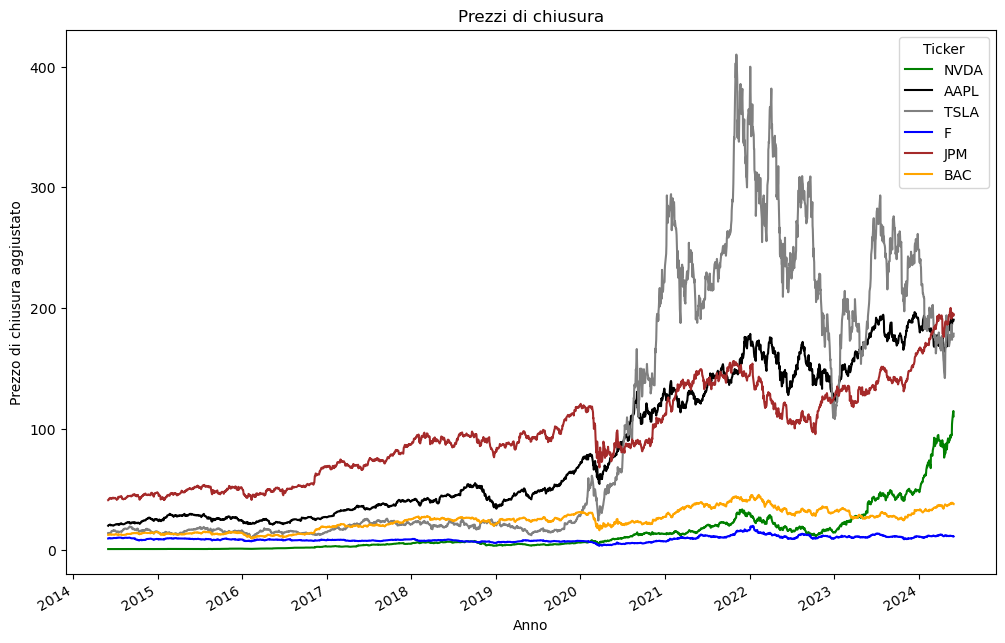

In [5]:
# plot dei prezzi di chiusura usando un grafico

# assegno i colori ai titoli
colors = ["green", "black", "gray", "blue", "brown", "orange"] 
data.plot(color = colors, figsize=(12, 8))
# definisco titolo, label per ascisse, label per ordinate 
plt.title('Prezzi di chiusura')
plt.xlabel('Anno')
plt.ylabel('Prezzo di chiusura aggiustato')
# mostro il grafico 
plt.show()



In [6]:
### STATISTICHE DESCRITTIVE

In [7]:
## RENDIMENTI 

# rendimento netto
r_netti = data.pct_change(1).dropna()
r_netti = r_netti.rename(columns=lambda x: x + '_R_NETTI')
r_netti.head()


Ticker,NVDA_R_NETTI,AAPL_R_NETTI,TSLA_R_NETTI,F_R_NETTI,JPM_R_NETTI,BAC_R_NETTI
Date,,,,,,
2014-06-03,-0.004224,0.014141,0.001173,0.006691,0.004517,-0.003277
2014-06-04,0.001061,0.011419,-0.004636,0.014502,0.001439,0.000000
2014-06-05,0.004237,0.003924,0.014265,-0.006551,0.017062,0.014464
2014-06-06,0.003692,-0.002750,0.006138,0.023981,0.006004,0.010369
2014-06-09,0.001051,0.016001,-0.013739,-0.004684,0.007899,0.016036


In [8]:
# rendimento lordo
r_lordi = data/data.shift(1)
r_lordi = r_lordi.dropna()
r_lordi = r_lordi.rename(columns=lambda x: x + '_R_LORDI')
r_lordi.head()

Ticker,NVDA_R_LORDI,AAPL_R_LORDI,TSLA_R_LORDI,F_R_LORDI,JPM_R_LORDI,BAC_R_LORDI
Date,,,,,,
2014-06-03,0.995776,1.014141,1.001173,1.006691,1.004517,0.996723
2014-06-04,1.001061,1.011419,0.995364,1.014502,1.001439,1.000000
2014-06-05,1.004237,1.003924,1.014265,0.993449,1.017062,1.014464
2014-06-06,1.003692,0.997250,1.006138,1.023981,1.006004,1.010369
2014-06-09,1.001051,1.016001,0.986261,0.995316,1.007899,1.016036


In [9]:
### rendimendo logaritmico
r_log = np.log(r_lordi)
r_log = r_log.rename(columns=lambda x: x.replace('_R_LORDI', '_R_LOG'))
r_log.tail()

Ticker,NVDA_R_LOG,AAPL_R_LOG,TSLA_R_LOG,F_R_LOG,JPM_R_LOG,BAC_R_LOG
Date,,,,,,
2024-05-23,0.089106,-0.021283,-0.036008,0.006628,-0.007034,-0.014950
2024-05-24,0.025398,0.016452,0.031166,0.004120,0.019064,0.013440
2024-05-28,0.067476,0.000053,-0.013989,-0.040274,-0.006047,-0.009618
2024-05-29,0.008080,0.001578,-0.003173,-0.010327,-0.006992,-0.015377
2024-05-30,-0.038394,0.005241,0.014649,0.018003,0.006139,-0.002327


In [10]:
### rendimento composto 
r_comp = np.cumprod(r_lordi)
r_comp = r_comp.rename(columns=lambda x: x.replace('_R_LORDI', '_R_COMP'))
r_comp.head()

Ticker,NVDA_R_COMP,AAPL_R_COMP,TSLA_R_COMP,F_R_COMP,JPM_R_COMP,BAC_R_COMP
Date,,,,,,
2014-06-03,0.995776,1.014141,1.001173,1.006691,1.004517,0.996723
2014-06-04,0.996832,1.025722,0.996531,1.021289,1.005962,0.996723
2014-06-05,1.001056,1.029746,1.010747,1.014599,1.023126,1.011140
2014-06-06,1.004752,1.026915,1.016952,1.038929,1.029268,1.021625
2014-06-09,1.005808,1.043347,1.002980,1.034063,1.037399,1.038008


In [11]:
### rendimento composto annuo 
years = (end - start).days / 365.25  # calcolo durata in anni
r_comp_annuo = (r_comp.iloc[-1] / r_comp.iloc[0]) ** (1 / years) - 1
r_comp_annuo

Ticker
NVDA_R_COMP    0.734167
AAPL_R_COMP    0.252418
TSLA_R_COMP    0.293199
F_R_COMP       0.016443
JPM_R_COMP     0.168229
BAC_R_COMP     0.119504
dtype: float64

In [12]:
# grafico ritorni netti e logaritmici 
# funzione che prende in input il ritorno netto, logaritmico, titolo e frequenza (default mensile) 
def plot_rendimenti(df_netti, df_log, ticker, f = 'ME'):


    plt.suptitle(f"Grafico dei Rendimenti semplici e logaritmici - {ticker}", fontsize=16) 
    
    plt.subplot(2, 1, 1)
    # grafico rendimento netto 
    df_netti[ticker + "_R_NETTI"].groupby(pd.Grouper(freq=f)).last().plot( figsize = (10,7)) # raggruppo basandomi sulla frequenza passata in input
    plt.xlabel("Data")
    plt.ylabel("Rendimento Netto")
    plt.grid(True)
    plt.subplot(2, 1, 2)
    df_log[ticker + "_R_LOG"].groupby(pd.Grouper(freq=f)).last().plot( figsize = (10,7), color='green')
    plt.xlabel("Data")
    plt.ylabel("Rendimento Logaritmico")
    plt.grid(True)
    plt.subplots_adjust(hspace=0.3)  
    plt.show()
    



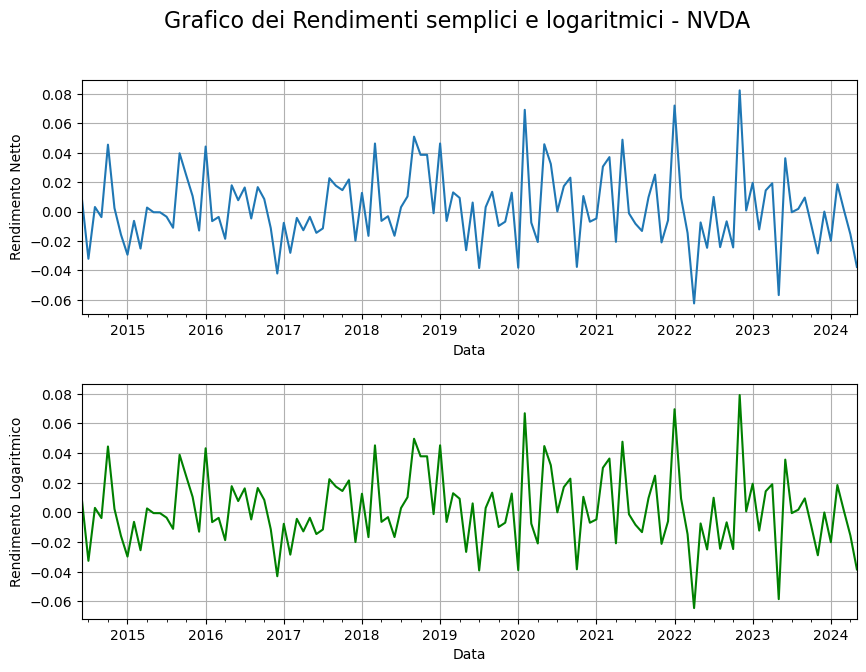

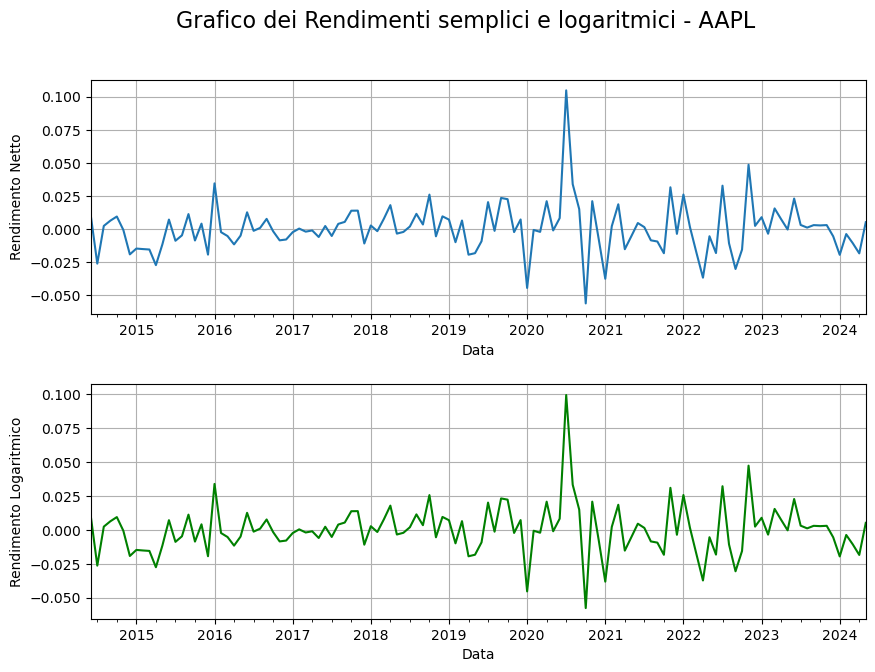

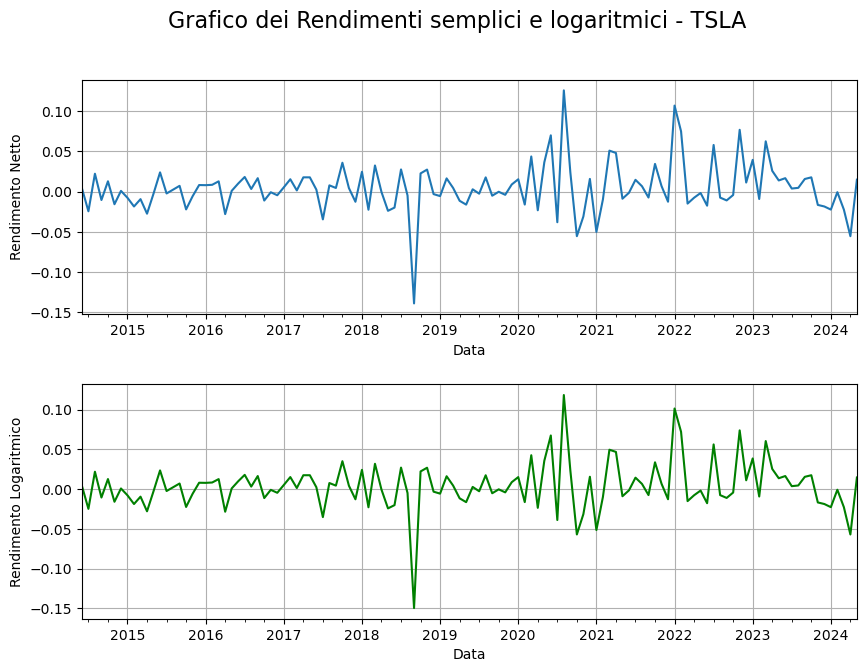

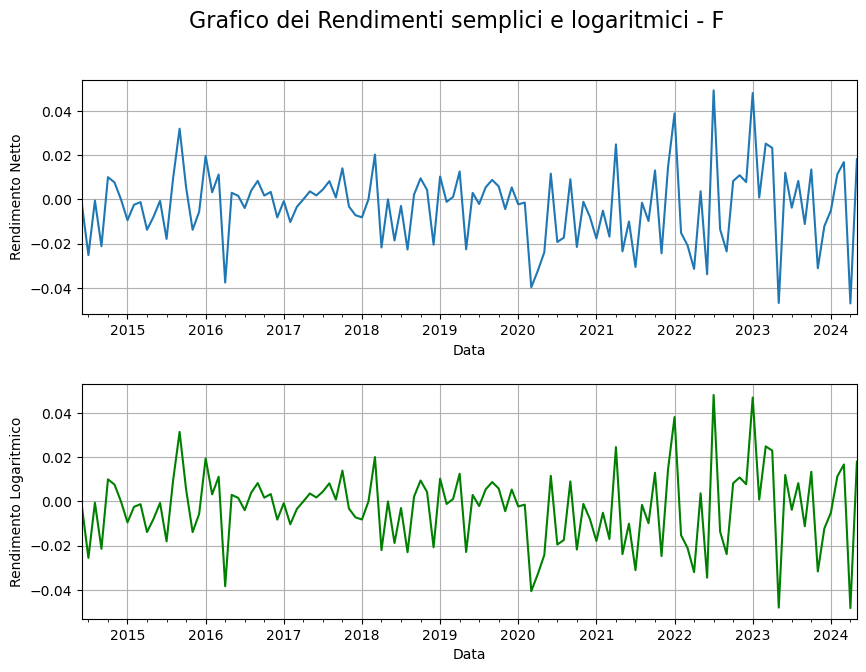

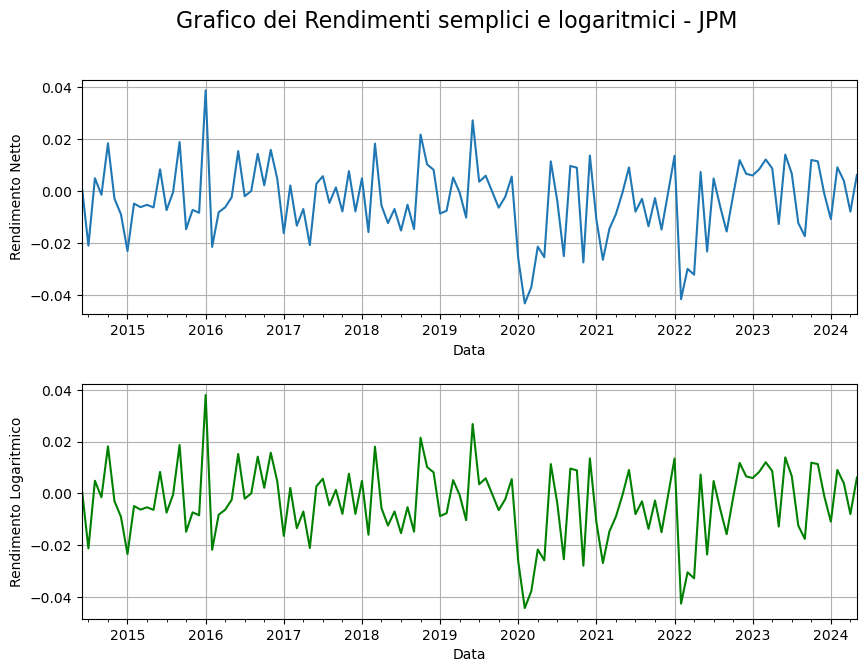

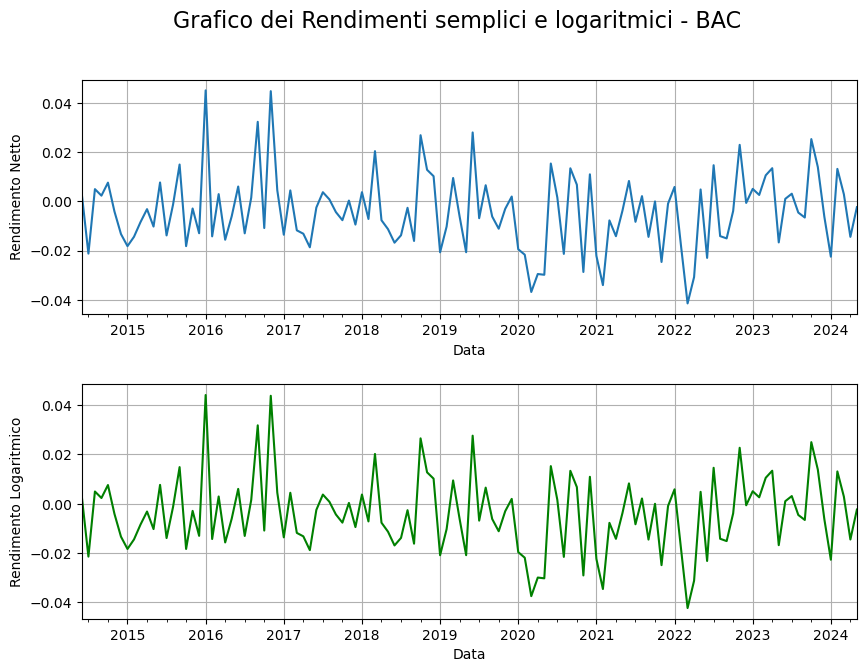

In [13]:
# stampo tutti i grafici dei rendimenti semplici e logaritmici per ogni titolo 
for ticker in tickers: 
    plot_rendimenti(r_netti, r_log, ticker, f='ME')

In [14]:
# funzione che stampa l'istogramma per il titolo specifico 
def plot_single_hist(df_netti, column):
    plt.figure(figsize=(8, 4))
    b = (np.max(df_netti[column], axis = 0) - np.min(df_netti[column], axis = 0)) / (2*stats.iqr(df_netti[column], axis = 0) / np.power(len(df_netti[column]), 1.0/3))
    df_netti[column].hist(bins=int(b), ec='black')
    plt.title(f'Histogram for {column.replace("_R_NETTI", "")}')
    plt.xlabel("Ritorno netto")
    plt.ylabel('Densità di frequenza')
    plt.grid(True)
    plt.show()

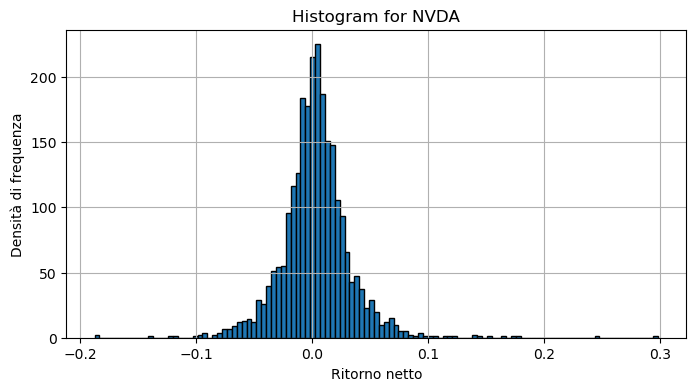

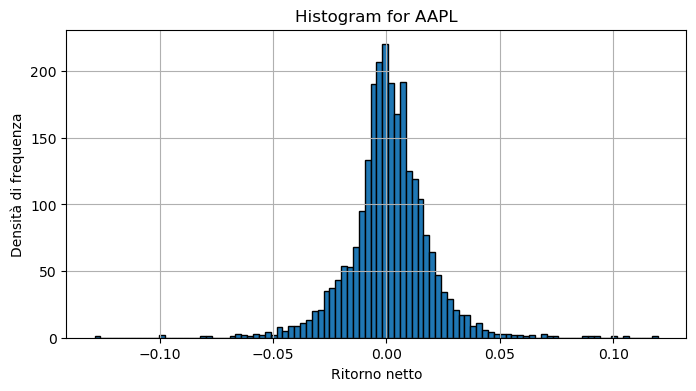

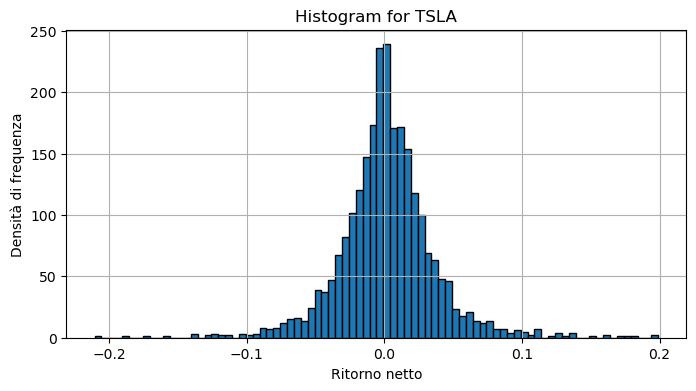

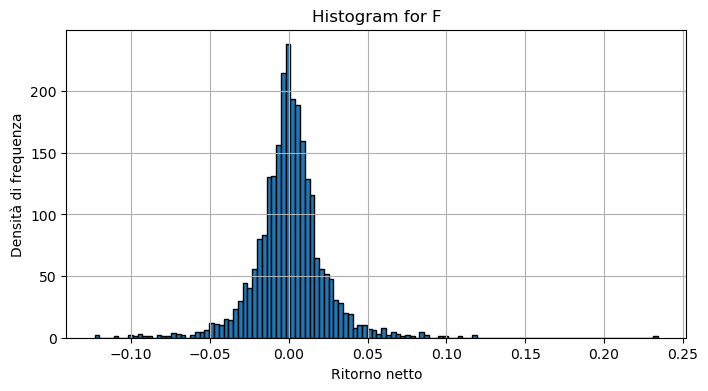

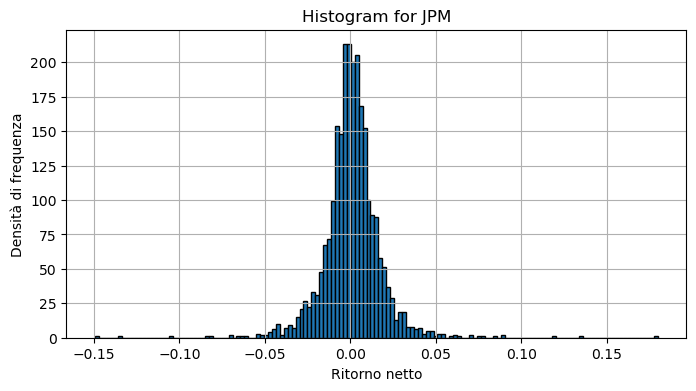

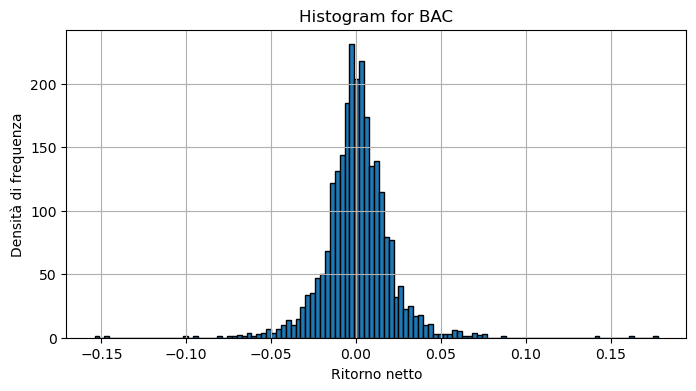

Ticker
NVDA_R_NETTI    0.029824
AAPL_R_NETTI    0.017841
TSLA_R_NETTI    0.034993
F_R_NETTI       0.022087
JPM_R_NETTI     0.016972
BAC_R_NETTI     0.019474
dtype: float64


In [15]:
# istogramma singolo
for col in r_netti:
    plot_single_hist(r_netti, col)

# dispersione dei titoli
print(r_netti.std())


In [16]:
# funzione che stampa il grafico a 3 sezioni
def plot_3_section_diagnostic_graph(df_netti, column):
    # istogramma con kernel density
    plt.figure(figsize=(8, 4))
    title_column = column.replace("_R_NETTI", "")
    df_netti[column].hist(bins=55, density=True,  ec='black')
    df_netti[column].plot.kde(color='red', linewidth=2, label='KDE')
    plt.title(f'Istogramma con kernel density - {title_column}')
    plt.xlabel("Ritorno Netto")
    plt.ylabel('Densità di frequenza')
    plt.legend()
    plt.grid(True)
    plt.show()
    # boxplot 
    plt.title(f'Boxplot - {title_column}')
    ax = df_netti[column].plot(kind = 'box', figsize = (8,4))
    ax.set_xticklabels([])
    plt.ylabel("Ritorno Netto")
    plt.show()
    # qq-plot 
    f = plt.figure(figsize=(8,4))
    ax = f.add_subplot(111)
    stats.probplot(df_netti[col], dist='norm', plot=ax)
    plt.title(f'QQ plot - {title_column}')
    plt.grid();
    plt.show();
    
    

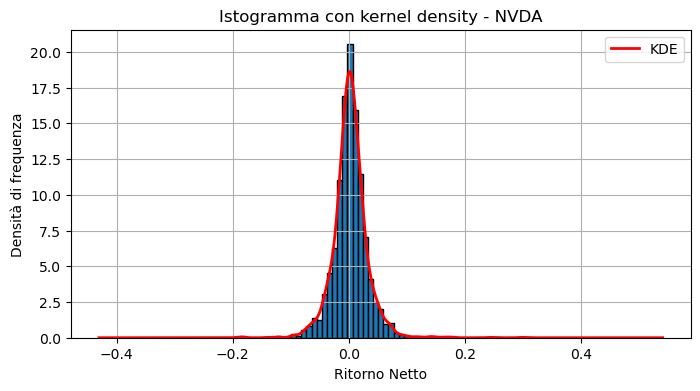

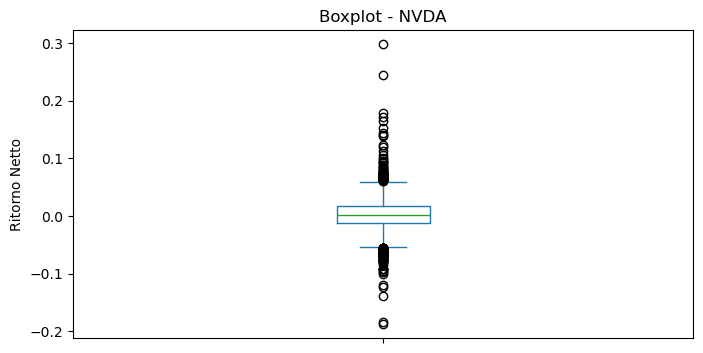

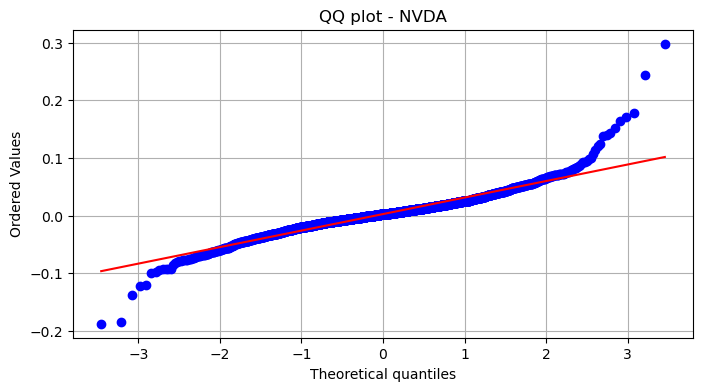

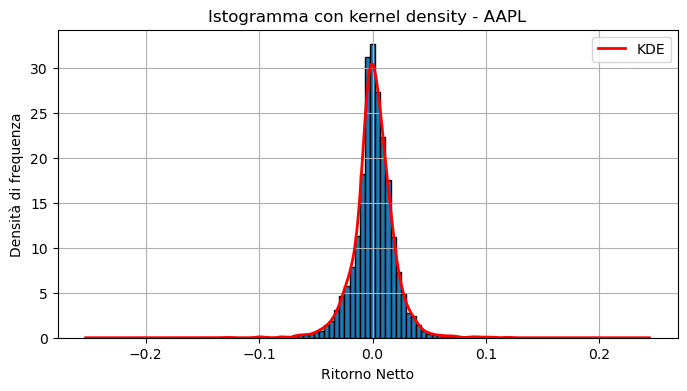

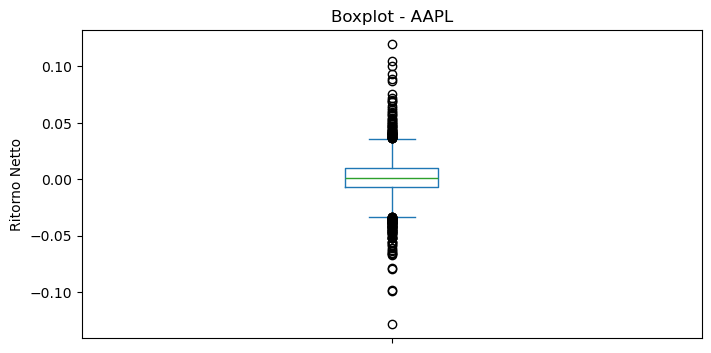

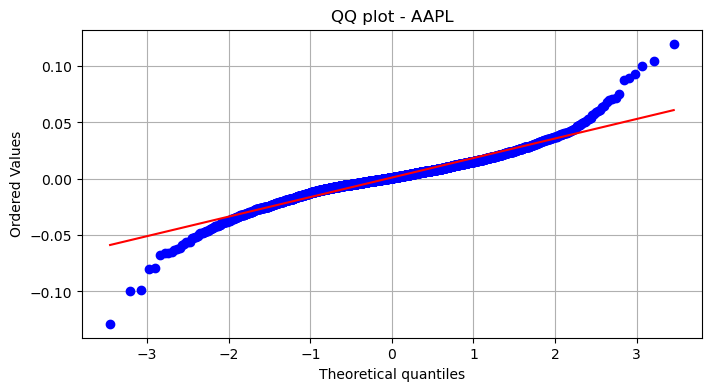

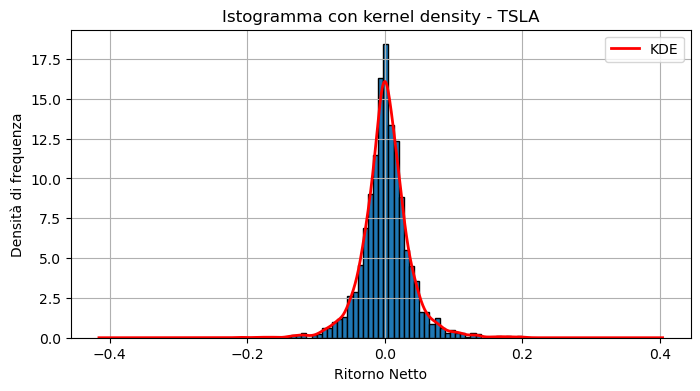

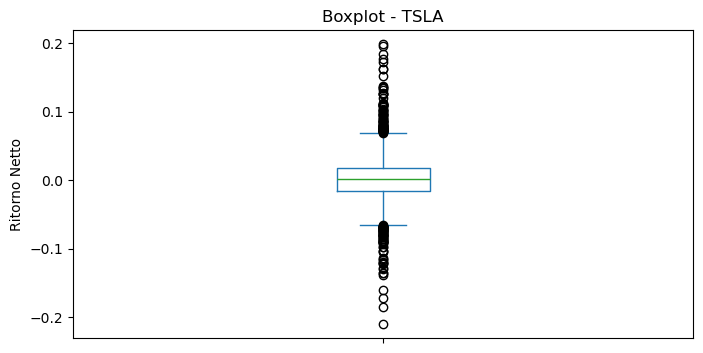

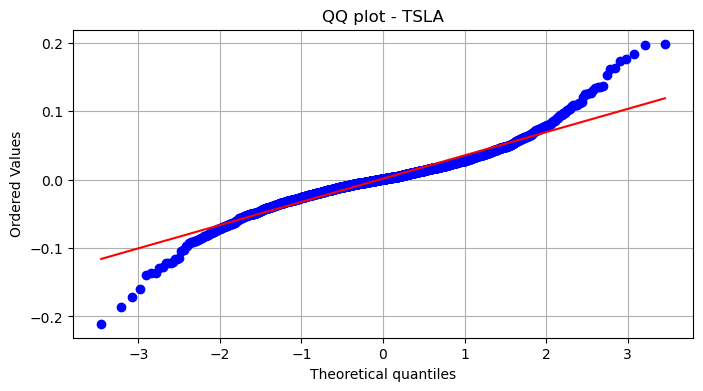

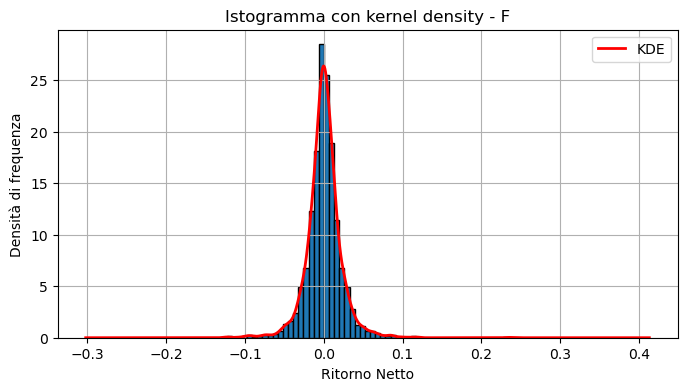

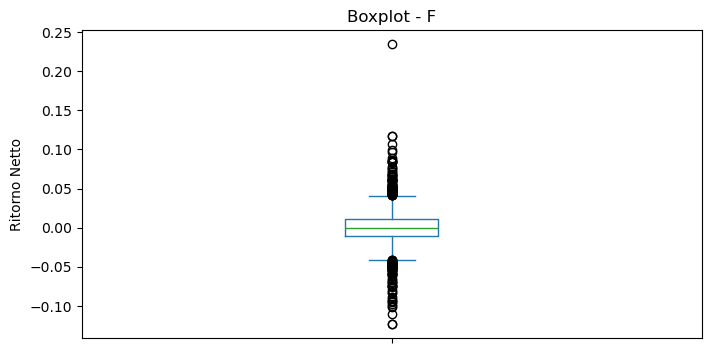

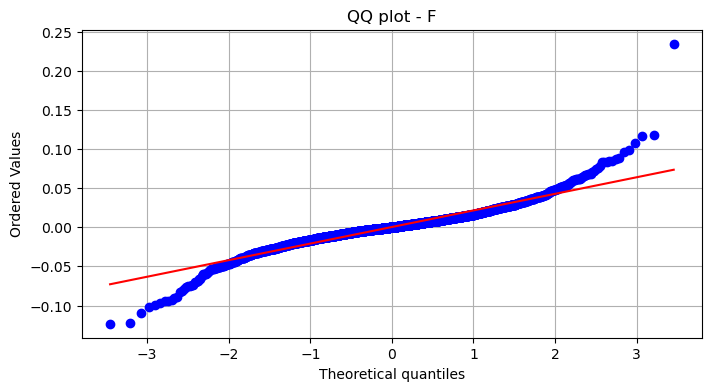

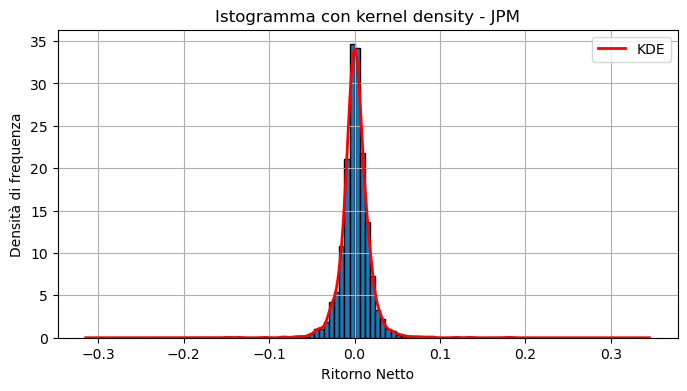

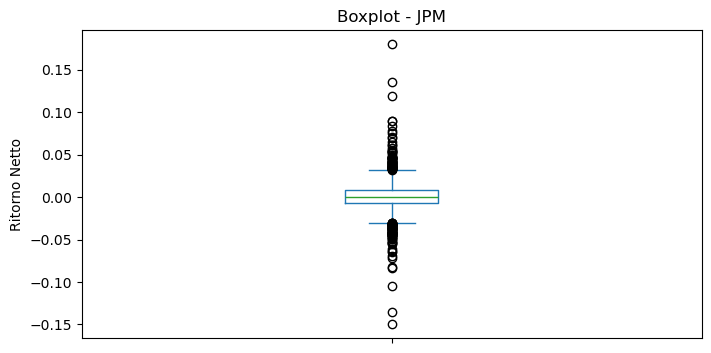

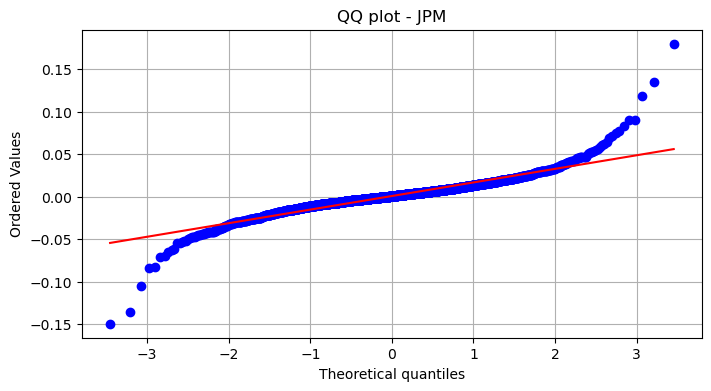

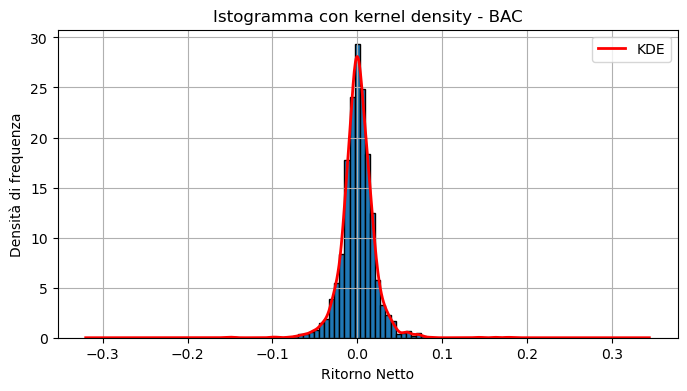

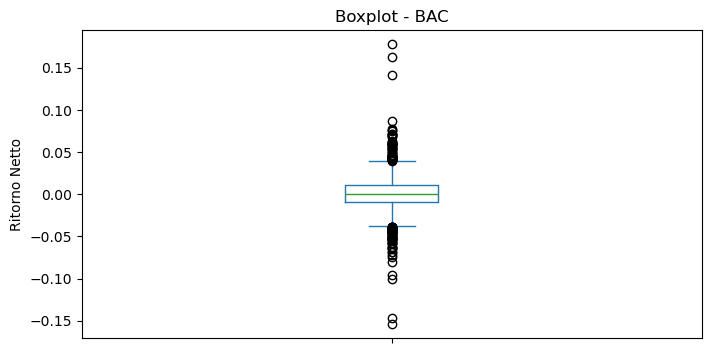

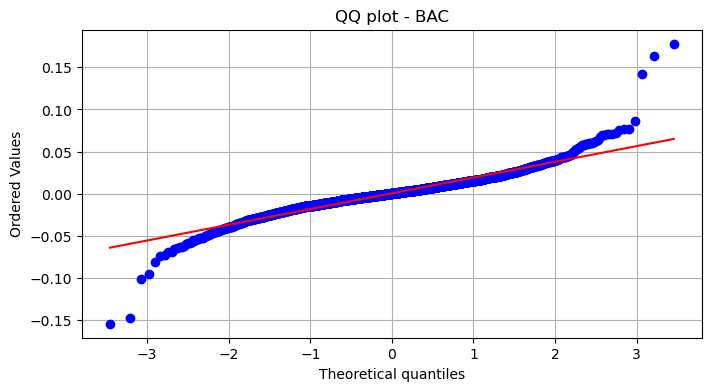

In [17]:
for col in r_netti:
    plot_3_section_diagnostic_graph(r_netti, col)

In [18]:
# Statistiche univariate annualizzate

stats = pd.DataFrame(index=r_netti.columns)
# Media
stats['Media'] = r_netti.mean()
# Varianza
stats['Varianza'] = r_netti.var()
    
# Deviazione standard
stats['Dev. Standard'] = r_netti.std()
    
# Asimmetria
stats['Asimmetria'] = r_netti.skew()
    
# Curtosi
stats['Curtosi'] = r_netti.kurt()

stats = stats.rename(index=lambda x: x.replace('_R_NETTI', ''))

stats

,Media,Varianza,Dev. Standard,Asimmetria,Curtosi
Ticker,,,,,
NVDA,0.002629,0.000889,0.029824,0.690360,9.271238
AAPL,0.001060,0.000318,0.017841,-0.018297,5.360849
TSLA,0.001634,0.001225,0.034993,0.209974,4.411360
F,0.000310,0.000488,0.022087,0.388256,8.930692
JPM,0.000764,0.000288,0.016972,0.297654,14.113217
BAC,0.000637,0.000379,0.019474,0.282795,10.097547


In [19]:
# matrice di varianze e covarianze 
cov = r_netti.cov()
var = r_netti.var()
cov = cov.rename(index=lambda x: x.replace('_R_NETTI', ''), columns=lambda y: y.replace('_R_NETTI', ''))
var = var.rename(index=lambda x: x.replace('_R_NETTI', ''))

In [20]:
var 

Ticker
NVDA    0.000889
AAPL    0.000318
TSLA    0.001225
F       0.000488
JPM     0.000288
BAC     0.000379
dtype: float64

In [21]:
cov

Ticker,NVDA,AAPL,TSLA,F,JPM,BAC
Ticker,,,,,,
NVDA,0.000889,0.000289,0.000419,0.000224,0.000175,0.000197
AAPL,0.000289,0.000318,0.000265,0.000140,0.000131,0.000146
TSLA,0.000419,0.000265,0.001225,0.000245,0.000156,0.000183
F,0.000224,0.000140,0.000245,0.000488,0.000208,0.000238
JPM,0.000175,0.000131,0.000156,0.000208,0.000288,0.000296
BAC,0.000197,0.000146,0.000183,0.000238,0.000296,0.000379


In [22]:
# Correlazione rendimenti 
corr = r_netti.corr()
corr = corr.rename(index=lambda x: x.replace('_R_NETTI', ''), columns=lambda y: y.replace('_R_NETTI', ''))
corr.style.background_gradient(axis=0, cmap='YlOrRd')


Ticker,NVDA,AAPL,TSLA,F,JPM,BAC
Ticker,,,,,,
NVDA,1.000000,0.543972,0.401633,0.340553,0.345753,0.339758
AAPL,0.543972,1.000000,0.425149,0.354447,0.433365,0.418809
TSLA,0.401633,0.425149,1.000000,0.316592,0.262753,0.268914
F,0.340553,0.354447,0.316592,1.000000,0.555403,0.553347
JPM,0.345753,0.433365,0.262753,0.555403,1.000000,0.895274
BAC,0.339758,0.418809,0.268914,0.553347,0.895274,1.000000


In [113]:
# Andamento correlazione nel tempo dei titoli facenti parte dello stesso settore 

# Funzione per plot andamento correlazione tra due titoli 
def correlation_plot(df_netti, title_1, title_2):
    rolling_corr = df_netti[title_1].rolling(window=252).corr(df_netti[title_2])
    plt.figure(figsize=(12, 6))
    rolling_corr.plot(title=f'Correlazione nel tempo tra {title_1.replace("_R_NETTI", "")} e {title_2.replace("_R_NETTI", "")}')
    plt.ylabel('Correlazione')
    plt.show()

In [115]:
# Scatter plot - grafico dispersione rendimenti di due titoli 
def scatterplot_returns(df_netti, title_1, title_2): 
    m, b = np.polyfit(df_netti[title_1], df_netti[title_2], 1)
    line = m * df_netti[title_1] + b
    plt.figure(figsize=(8, 8))
    plt.scatter(df_netti[title_1], df_netti[title_2], alpha=0.5)
    plt.title(f'Scatter plot dei rendimenti: {title_1.replace("_R_NETTI", "")} - {title_2.replace("_R_NETTI", "")}')
    plt.xlabel(f'Rendimenti {title_1.replace("_R_NETTI", "")}')
    plt.ylabel(f'Rendimenti {title_2.replace("_R_NETTI", "")}')
    plt.plot(df_netti[title_1], line, color='red')
    plt.show()
    

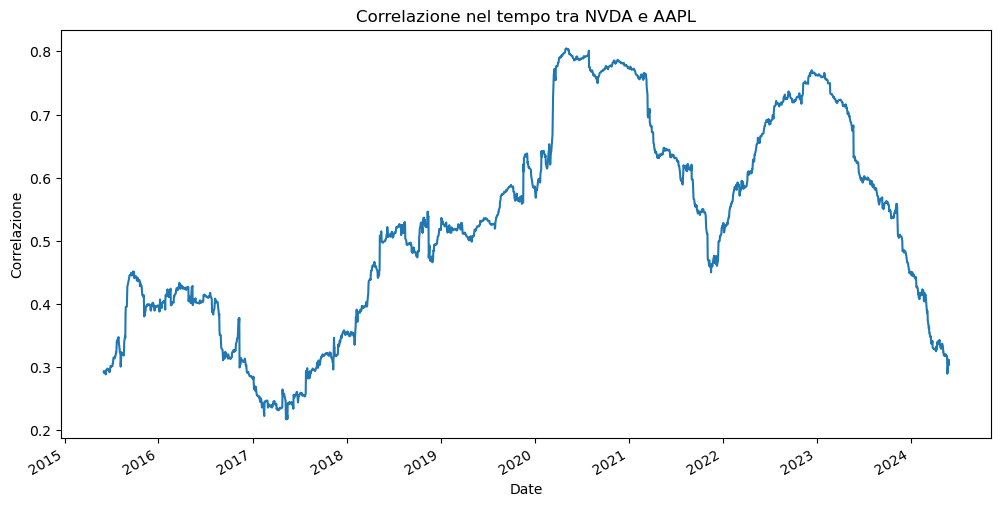

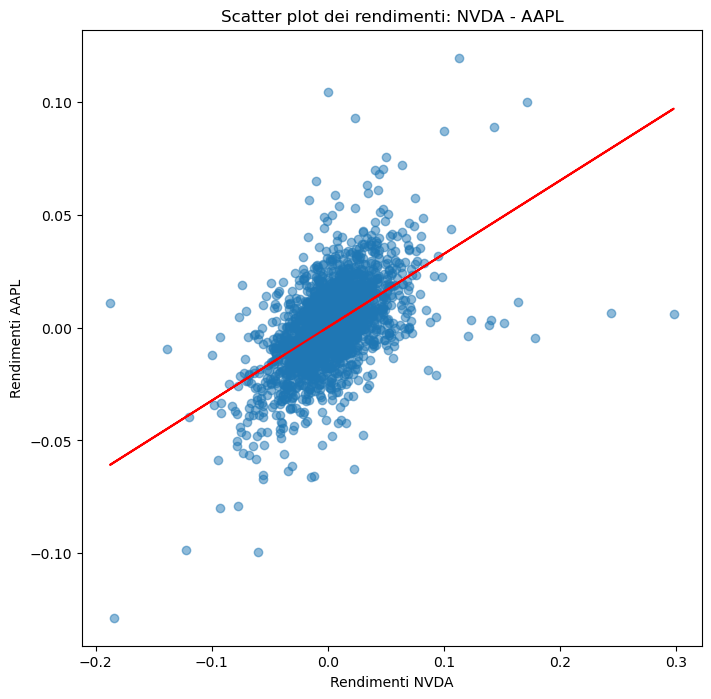

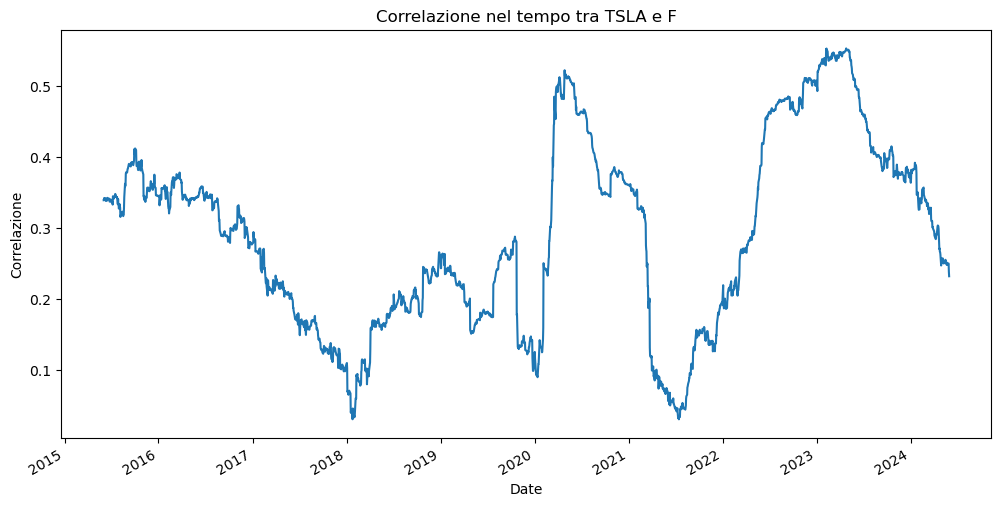

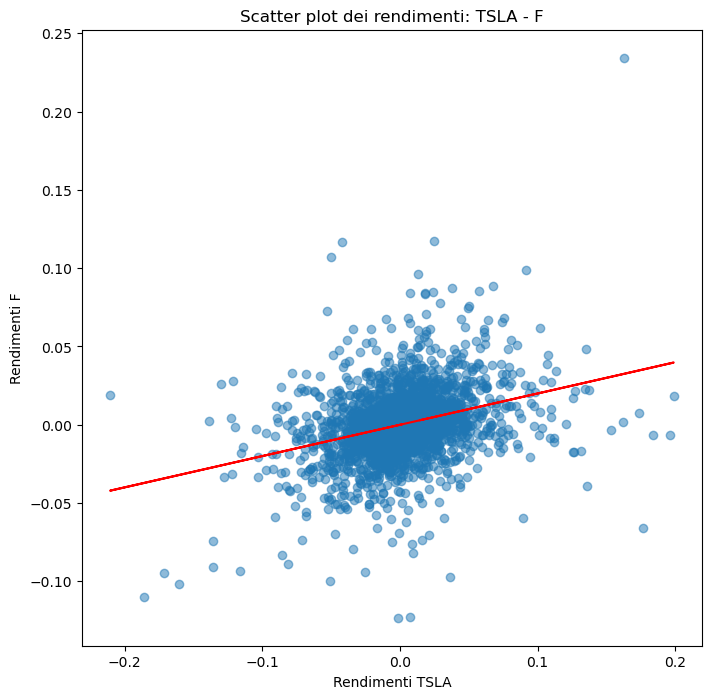

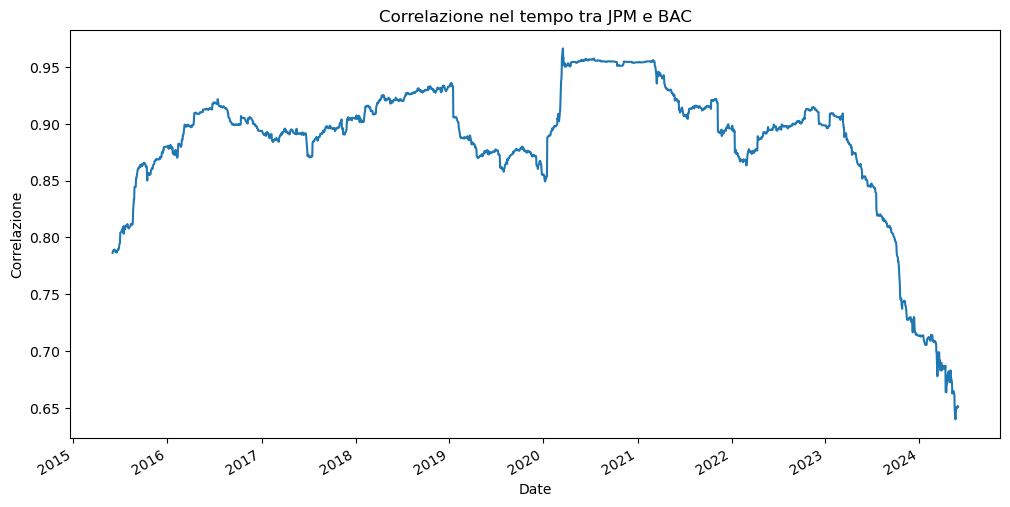

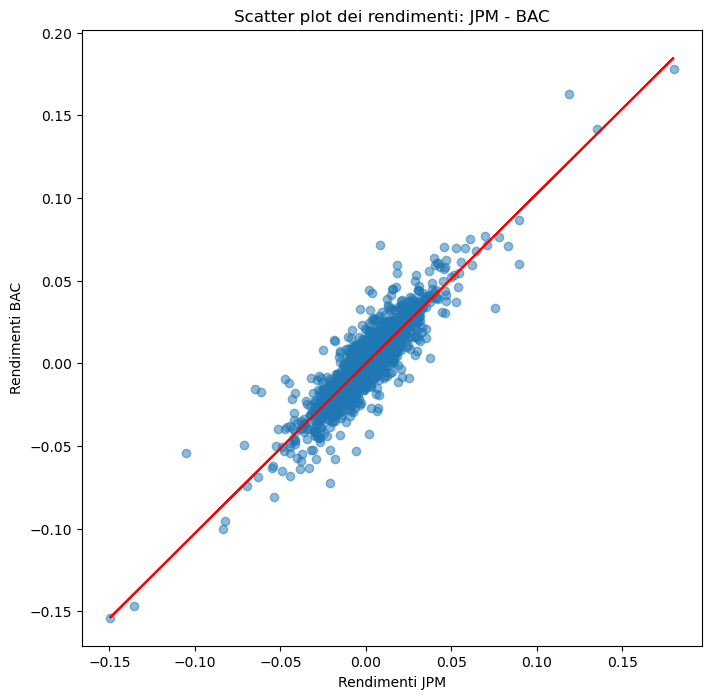

In [117]:
correlation_plot(r_netti, "NVDA_R_NETTI", "AAPL_R_NETTI")
scatterplot_returns(r_netti, "NVDA_R_NETTI", "AAPL_R_NETTI")
correlation_plot(r_netti, "TSLA_R_NETTI", "F_R_NETTI")
scatterplot_returns(r_netti, "TSLA_R_NETTI", "F_R_NETTI")
correlation_plot(r_netti, "JPM_R_NETTI", "BAC_R_NETTI")
scatterplot_returns(r_netti, "JPM_R_NETTI", "BAC_R_NETTI")

In [26]:
# Funzione per stampare andamento prezzo e previsione ARIMA  
def plot_forecast_vs_actual(train_data, test_data, forecast, actual_forecast, conf_int, ticker):
    plt.figure(figsize=(12, 6))
    plt.plot(train_data.index, train_data.values, label='Train', color='black')
    plt.plot(test_data.index, test_data.values, label='Test', color='green')
    plt.plot(actual_forecast.index, actual_forecast.values, color='orange', label='Actual movement last 10 months')
    plt.plot(forecast.index, forecast.values, color='blue', label='Forecast')
    plt.fill_between(forecast.index, 
                    conf_int[:, 0], 
                    conf_int[:, 1], 
                    color='pink', alpha=0.3, label='Confidence Interval')
    
    plt.title(f'{ticker} Stock Price - Full History and Forecast')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

# Funzione per stampare grafico di comparazione tra prezzi attuali e prezzi di previsione ARIMA 
def compare_result(actual, forecast, ticker):
    comp_forecast_actual = pd.DataFrame()
    comp_forecast_actual[f'Actual Price {ticker}'] = actual
    comp_forecast_actual[f'Prediction {ticker}'] = forecast
    comp_forecast_actual.index = comp_forecast_actual.index.strftime('%Y-%m-%d')
    comp_forecast_actual.plot(kind='bar', figsize=(15, 10))
    plt.title('Actual Price vs Prediction')
    plt.ylabel('Price')
    plt.xlabel('Time Period')
    plt.grid(True)
    plt.show()



Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-111.984, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-115.227, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-113.551, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-113.525, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-106.778, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.087 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  59.613
Date:                Sun, 01 Jun 2025   AIC                           -115.227
Time:                        16:20:42   BIC                           -110.488
Sample:                    06-30-2014   HQIC                          -113.328
                         - 01-31-2021                                       

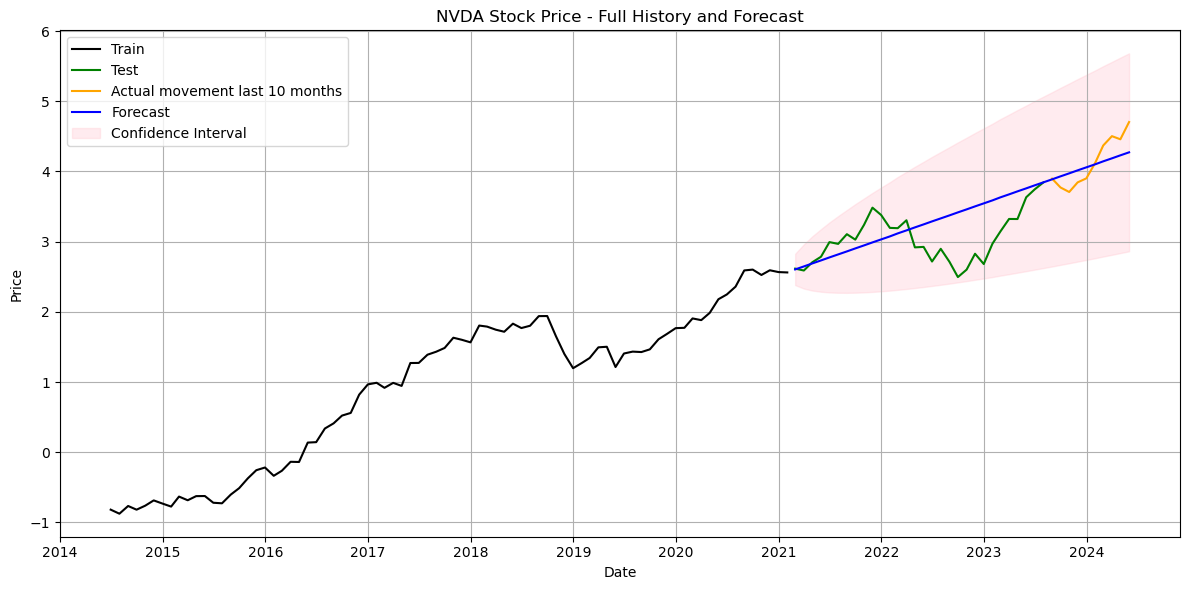

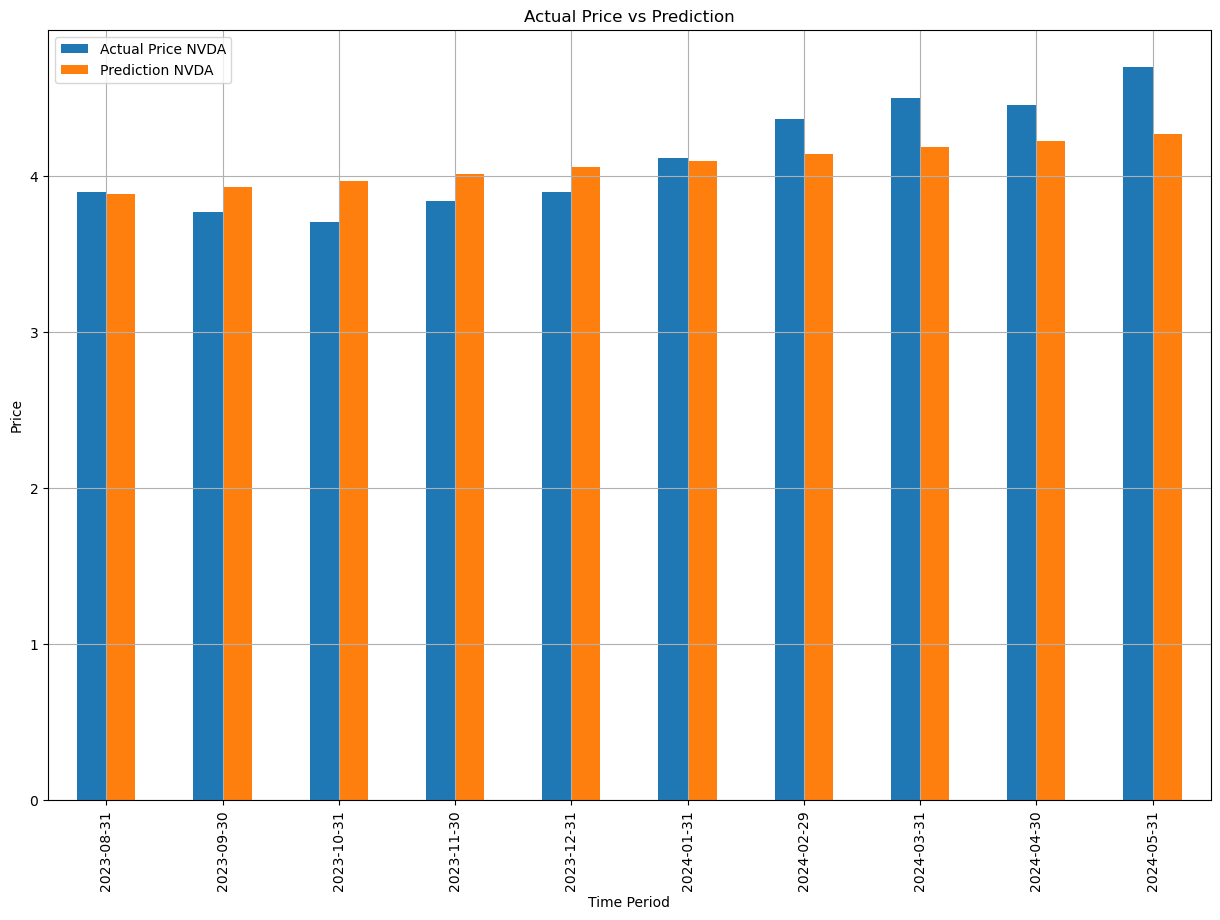

In [27]:
# ANALISI DI PREVISIONE NVIDIA 

ticker = 'NVDA'

data_to_train = data[ticker].resample("ME").last().dropna()
data_to_train = np.log(data_to_train)

n, m, l = 80, 30, 10

# Split training (80 mesi) and test (30 mesi)
train = data_to_train.iloc[:n]
test = data_to_train.iloc[n:m + n]  
actual = data_to_train.iloc[-l:]  # Ultimi 10 mesi per forecast

    
# Automatizing ARIMA model with best parameters 
model_auto = auto_arima(train, 
                   start_p=1, start_q=1,
                   max_p=3, max_q=3,
                   seasonal=False,
                   stepwise=True,
                   trace=True)
print(model_auto.summary())

# miglior parametri trovati per modello ARIMA su train set 
best_order = model_auto.order
print(f"Auto ARIMA found that the best order is {best_order}")


# effettuo previsione su 40 mesi, 30 test + 10 finali 
forecast, conf_int = model_auto.predict(n_periods=len(test) + 10, return_conf_int=True, alpha = 0.05)

# stampo a grafico andamento prezzo con previsione 
plot_forecast_vs_actual(train, test, forecast, actual, conf_int, ticker)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(actual, forecast[-10:])
print("MAE:", mae)

# Mean Squared Error (MSE)
mse = mean_squared_error(actual, forecast[-10:])
print("MSE:", mse)

# Root Mean Squared Error (RMSE)
rmse = root_mean_squared_error(actual, forecast[-10:]) 
print("RMSE:", rmse)


# Confronto prezzo attuale vs di previsione
compare_result(actual, forecast, ticker)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-167.249, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-169.914, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-168.219, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-168.332, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-165.565, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.072 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  86.957
Date:                Sun, 01 Jun 2025   AIC                           -169.914
Time:                        16:20:42   BIC                           -165.176
Sample:                    06-30-2014   HQIC                          -168.016
                         - 01-31-2021                                       

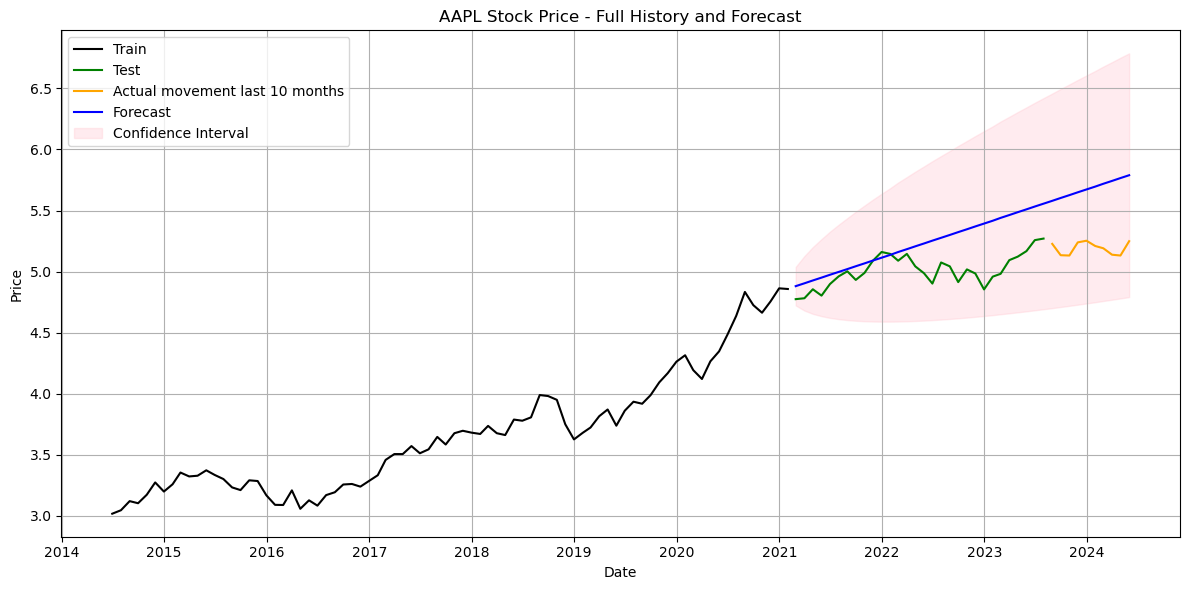

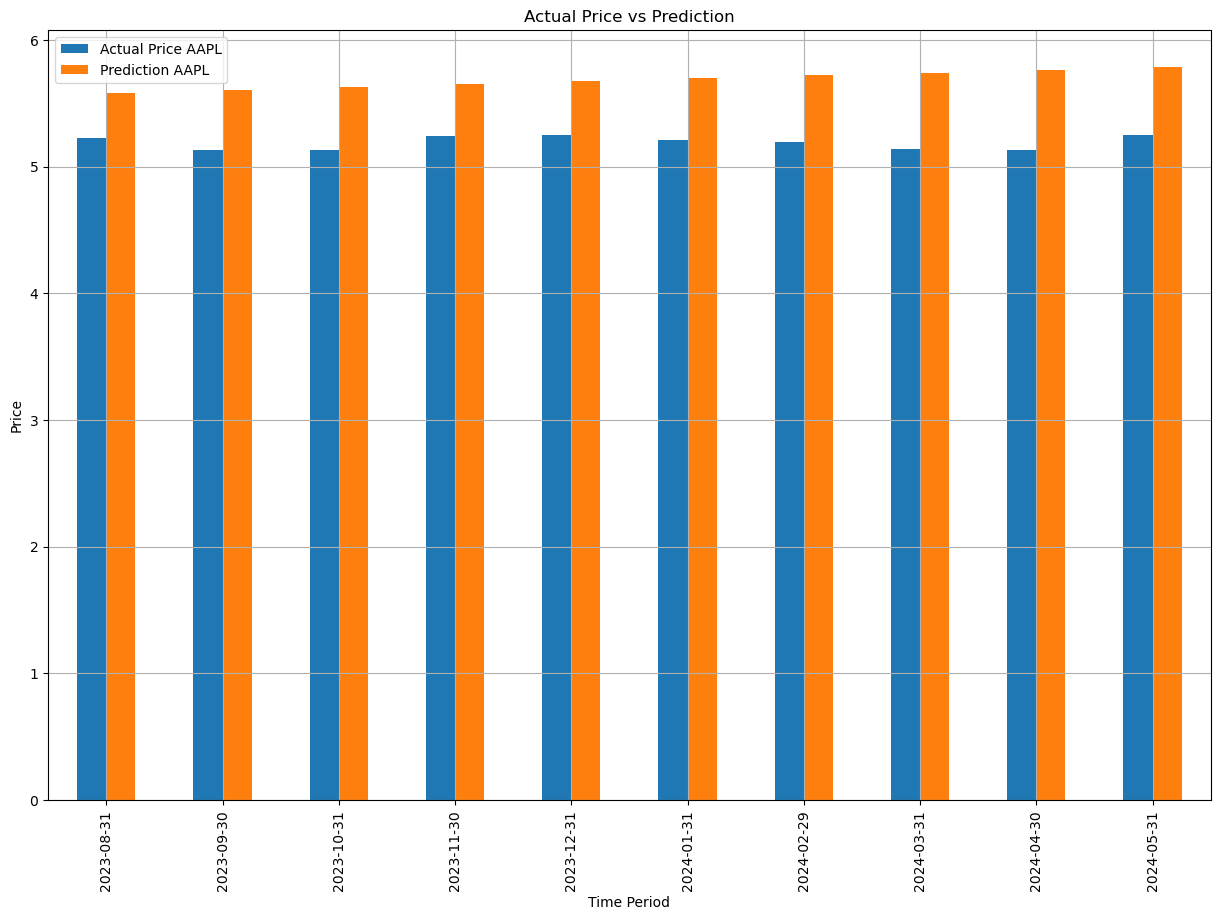

In [28]:
# ANALISI DI PREVISIONE APPLE  

ticker = 'AAPL'

data_to_train = data[ticker].resample("ME").last().dropna()
data_to_train = np.log(data_to_train)

n, m, l = 80, 30, 10

# Split training (80 mesi) and test (30 mesi)
train = data_to_train.iloc[:n]
test = data_to_train.iloc[n:m + n]  
actual = data_to_train.iloc[-l:]  # Ultimi 10 mesi per forecast

    
# Automatizing ARIMA model with best parameters 
model_auto = auto_arima(train, 
                   start_p=1, start_q=1,
                   max_p=3, max_q=3,
                   seasonal=False,
                   stepwise=True,
                   trace=True)
print(model_auto.summary())

# miglior parametri trovati per modello ARIMA su train set 
best_order = model_auto.order
print(f"Auto ARIMA found that the best order is {best_order}")


# effettuo previsione su 40 mesi, 30 test + 10 finali 
forecast, conf_int = model_auto.predict(n_periods=len(test) + 10, return_conf_int=True, alpha = 0.05)

# stampo a grafico andamento prezzo con previsione 
plot_forecast_vs_actual(train, test, forecast, actual, conf_int, ticker)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(actual, forecast[-10:])
print("MAE:", mae)

# Mean Squared Error (MSE)
mse = mean_squared_error(actual, forecast[-10:])
print("MSE:", mse)

# Root Mean Squared Error (RMSE)
rmse = root_mean_squared_error(actual, forecast[-10:]) 
print("RMSE:", rmse)


# Confronto prezzo attuale vs di previsione
compare_result(actual, forecast, ticker)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-161.291, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-159.733, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-158.341, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-158.500, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-161.687, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.058 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  81.843
Date:                Sun, 01 Jun 2025   AIC                           -161.687
Time:                        16:20:42   BIC                           -159.317
Sample:                    06-30-2014   HQIC                          -160.737
                         - 01-31-2021                                       

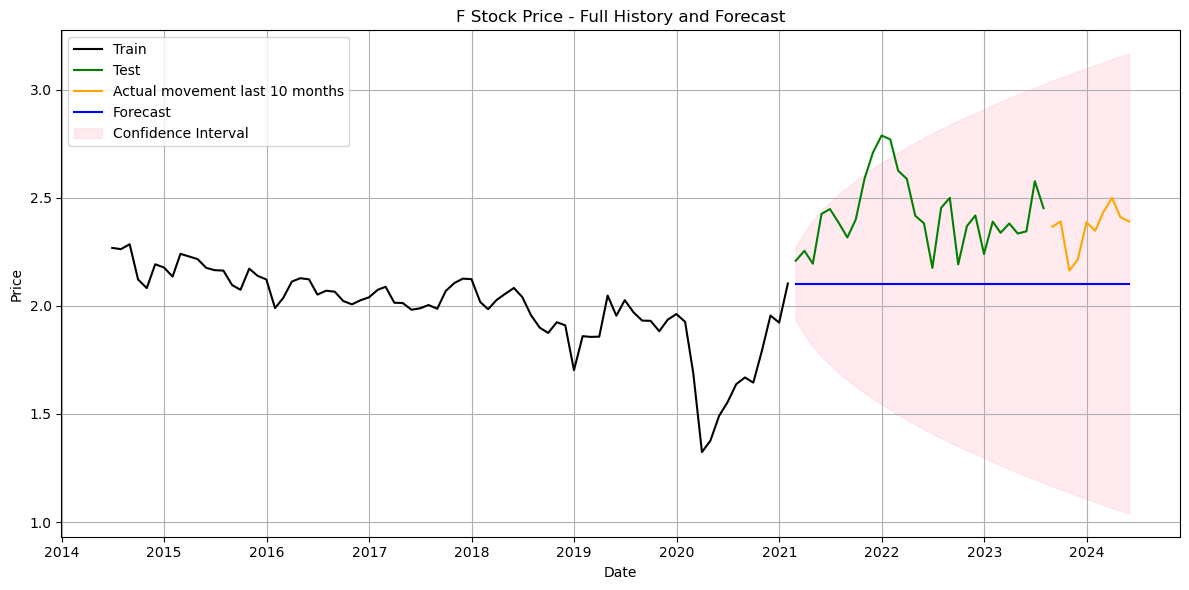

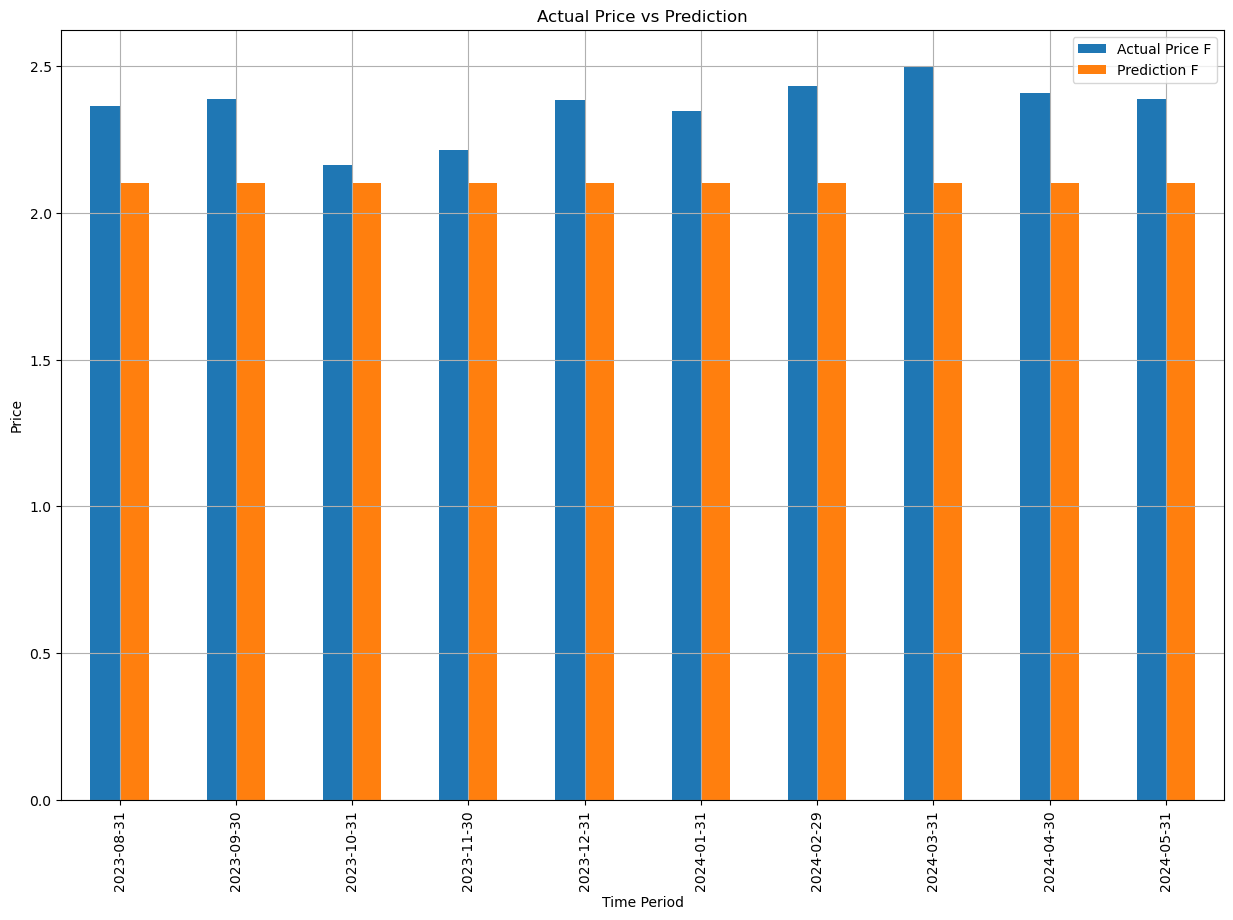

In [29]:
# ANALISI DI PREVISIONE FORD  

ticker = 'F'

data_to_train = data[ticker].resample("ME").last().dropna()
data_to_train = np.log(data_to_train)

n, m, l = 80, 30, 10

# Split training (80 mesi) and test (30 mesi)
train = data_to_train.iloc[:n]
test = data_to_train.iloc[n:m + n]  
actual = data_to_train.iloc[-l:]  # Ultimi 10 mesi per forecast

    
# Automatizing ARIMA model with best parameters 
model_auto = auto_arima(train, 
                   start_p=1, start_q=1,
                   max_p=3, max_q=3,
                   seasonal=False,
                   stepwise=True,
                   trace=True)
print(model_auto.summary())

# miglior parametri trovati per modello ARIMA su train set 
best_order = model_auto.order
print(f"Auto ARIMA found that the best order is {best_order}")


# effettuo previsione su 40 mesi, 30 test + 10 finali 
forecast, conf_int = model_auto.predict(n_periods=len(test) + 10, return_conf_int=True, alpha = 0.05)

# stampo a grafico andamento prezzo con previsione 
plot_forecast_vs_actual(train, test, forecast, actual, conf_int, ticker)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(actual, forecast[-10:])
print("MAE:", mae)

# Mean Squared Error (MSE)
mse = mean_squared_error(actual, forecast[-10:])
print("MSE:", mse)

# Root Mean Squared Error (RMSE)
rmse = root_mean_squared_error(actual, forecast[-10:]) 
print("RMSE:", rmse)


# Confronto prezzo attuale vs di previsione
compare_result(actual, forecast, ticker)

Performing stepwise search to minimize aic
 ARIMA(1,2,1)(0,0,0)[0] intercept   : AIC=-61.831, Time=0.04 sec
 ARIMA(0,2,0)(0,0,0)[0] intercept   : AIC=-15.372, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0] intercept   : AIC=-30.088, Time=0.02 sec
 ARIMA(0,2,1)(0,0,0)[0] intercept   : AIC=-63.749, Time=0.03 sec
 ARIMA(0,2,0)(0,0,0)[0]             : AIC=-17.362, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0] intercept   : AIC=-61.908, Time=0.03 sec
 ARIMA(1,2,2)(0,0,0)[0] intercept   : AIC=-59.750, Time=0.04 sec
 ARIMA(0,2,1)(0,0,0)[0]             : AIC=-64.017, Time=0.01 sec
 ARIMA(1,2,1)(0,0,0)[0]             : AIC=-62.245, Time=0.01 sec
 ARIMA(0,2,2)(0,0,0)[0]             : AIC=-62.433, Time=0.01 sec
 ARIMA(1,2,0)(0,0,0)[0]             : AIC=-32.074, Time=0.01 sec
 ARIMA(1,2,2)(0,0,0)[0]             : AIC=-60.017, Time=0.02 sec

Best model:  ARIMA(0,2,1)(0,0,0)[0]          
Total fit time: 0.242 seconds
                               SARIMAX Results                                
Dep. Variable:       

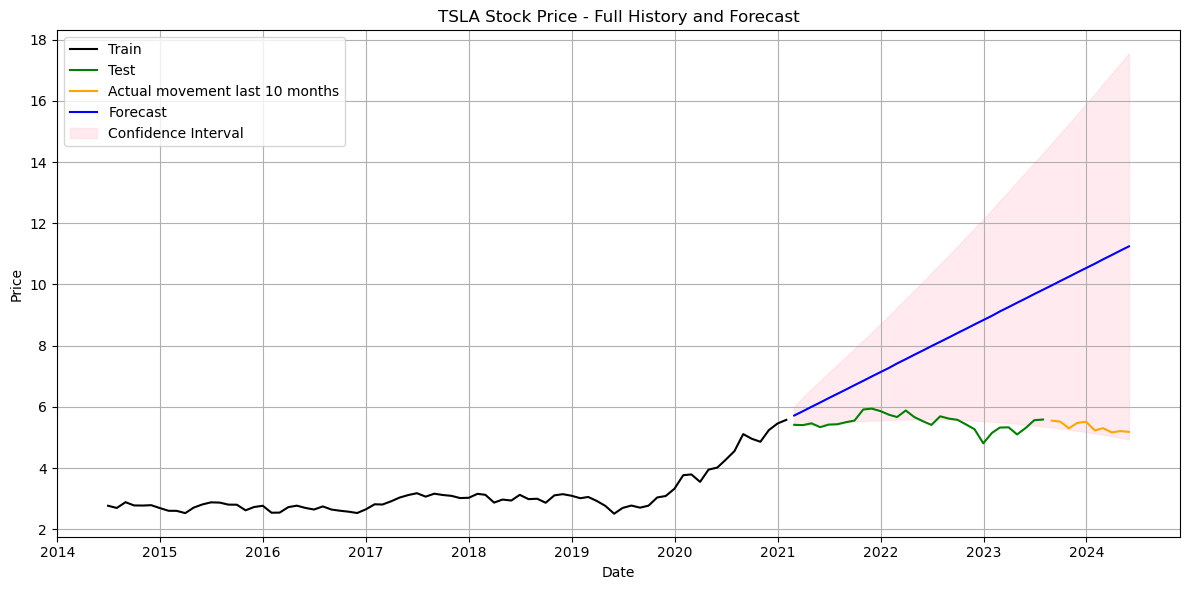

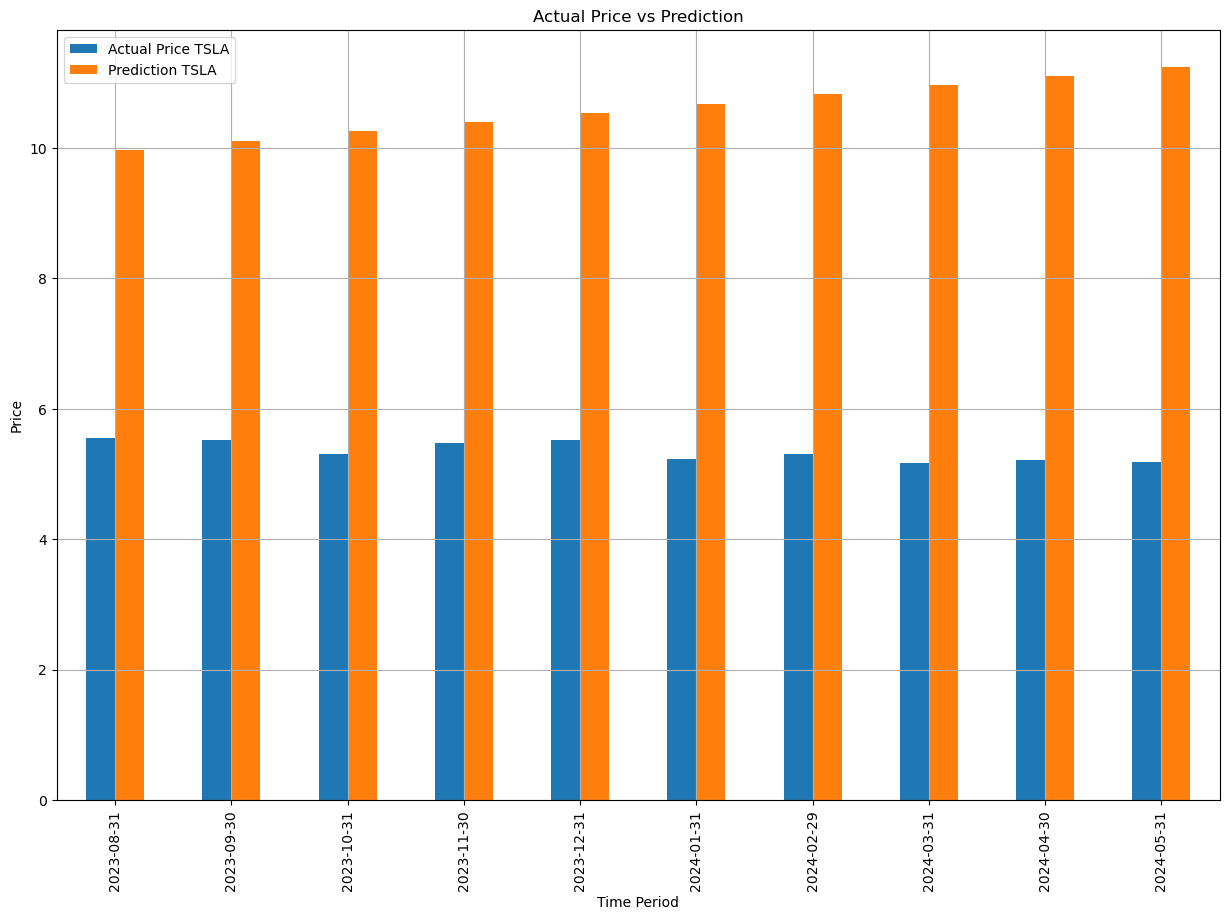

In [30]:
# ANALISI DI PREVISIONE TESLA 

ticker = 'TSLA'

data_to_train = data[ticker].resample("ME").last().dropna()
data_to_train = np.log(data_to_train)

n, m, l = 80, 30, 10

# Split training (80 mesi) and test (30 mesi)
train = data_to_train.iloc[:n]
test = data_to_train.iloc[n:m + n]  
actual = data_to_train.iloc[-l:]  # Ultimi 10 mesi per forecast

    
# Automatizing ARIMA model with best parameters 
model_auto = auto_arima(train, 
                   start_p=1, start_q=1,
                   max_p=3, max_q=3,
                   seasonal=False,
                   stepwise=True,
                   trace=True)
print(model_auto.summary())

# miglior parametri trovati per modello ARIMA su train set 
best_order = model_auto.order
print(f"Auto ARIMA found that the best order is {best_order}")


# effettuo previsione su 40 mesi, 30 test + 10 finali 
forecast, conf_int = model_auto.predict(n_periods=len(test) + 10, return_conf_int=True, alpha = 0.05)

# stampo a grafico andamento prezzo con previsione 
plot_forecast_vs_actual(train, test, forecast, actual, conf_int, ticker)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(actual, forecast[-10:])
print("MAE:", mae)

# Mean Squared Error (MSE)
mse = mean_squared_error(actual, forecast[-10:])
print("MSE:", mse)

# Root Mean Squared Error (RMSE)
rmse = root_mean_squared_error(actual, forecast[-10:]) 
print("RMSE:", rmse)


# Confronto prezzo attuale vs di previsione
compare_result(actual, forecast, ticker)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-161.291, Time=0.03 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-159.733, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-158.341, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-158.500, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-161.687, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.062 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  81.843
Date:                Sun, 01 Jun 2025   AIC                           -161.687
Time:                        16:20:43   BIC                           -159.317
Sample:                    06-30-2014   HQIC                          -160.737
                         - 01-31-2021                                       

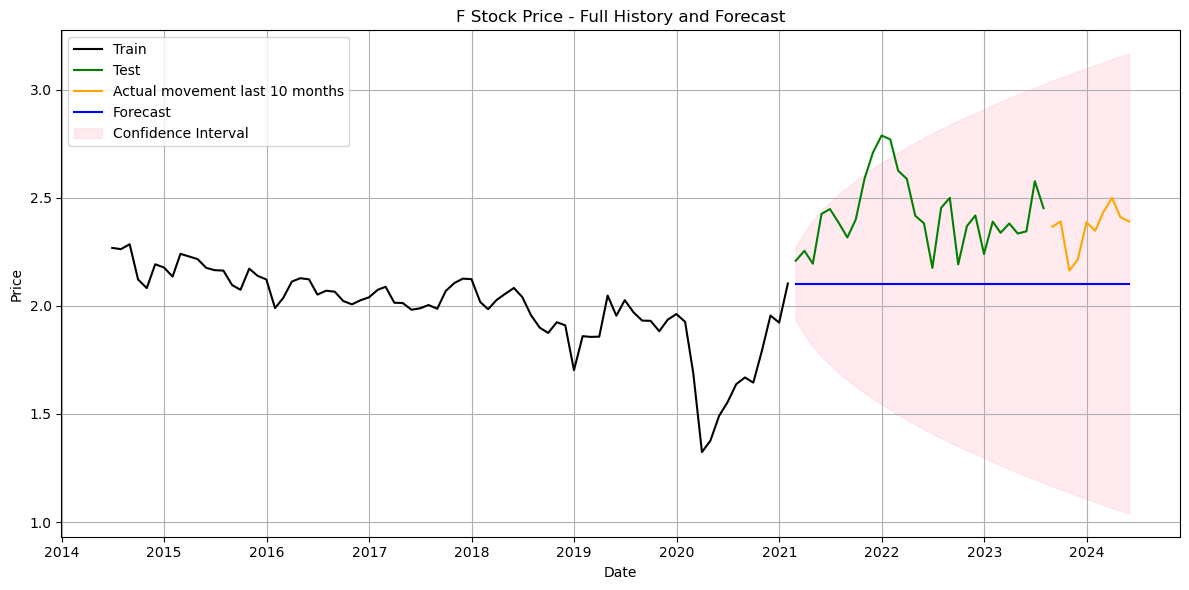

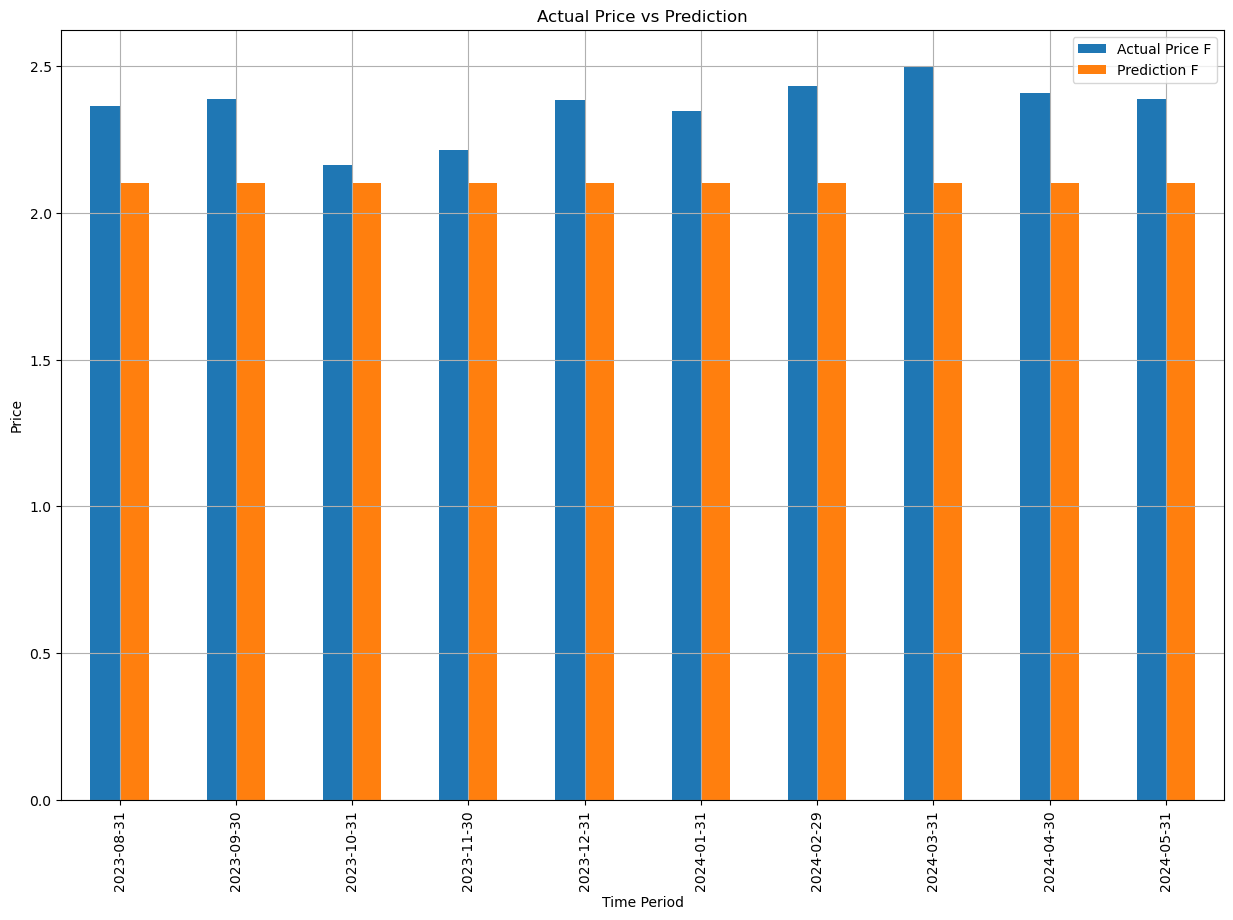

In [31]:
# ANALISI DI PREVISIONE FORD  

ticker = 'F'

data_to_train = data[ticker].resample("ME").last().dropna()
data_to_train = np.log(data_to_train)

n, m, l = 80, 30, 10

# Split training (80 mesi) and test (30 mesi)
train = data_to_train.iloc[:n]
test = data_to_train.iloc[n:m + n]  
actual = data_to_train.iloc[-l:]  # Ultimi 10 mesi per forecast

    
# Automatizing ARIMA model with best parameters 
model_auto = auto_arima(train, 
                   start_p=1, start_q=1,
                   max_p=3, max_q=3,
                   seasonal=False,
                   stepwise=True,
                   trace=True)
print(model_auto.summary())

# miglior parametri trovati per modello ARIMA su train set 
best_order = model_auto.order
print(f"Auto ARIMA found that the best order is {best_order}")


# effettuo previsione su 40 mesi, 30 test + 10 finali 
forecast, conf_int = model_auto.predict(n_periods=len(test) + 10, return_conf_int=True, alpha = 0.05)

# stampo a grafico andamento prezzo con previsione 
plot_forecast_vs_actual(train, test, forecast, actual, conf_int, ticker)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(actual, forecast[-10:])
print("MAE:", mae)

# Mean Squared Error (MSE)
mse = mean_squared_error(actual, forecast[-10:])
print("MSE:", mse)

# Root Mean Squared Error (RMSE)
rmse = root_mean_squared_error(actual, forecast[-10:]) 
print("RMSE:", rmse)


# Confronto prezzo attuale vs di previsione
compare_result(actual, forecast, ticker)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-194.076, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-198.075, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-196.075, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-196.076, Time=0.01 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-197.377, Time=0.00 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0] intercept
Total fit time: 0.058 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:               SARIMAX(0, 1, 0)   Log Likelihood                 101.037
Date:                Sun, 01 Jun 2025   AIC                           -198.075
Time:                        16:20:43   BIC                           -193.336
Sample:                    06-30-2014   HQIC                          -196.176
                         - 01-31-2021                                       

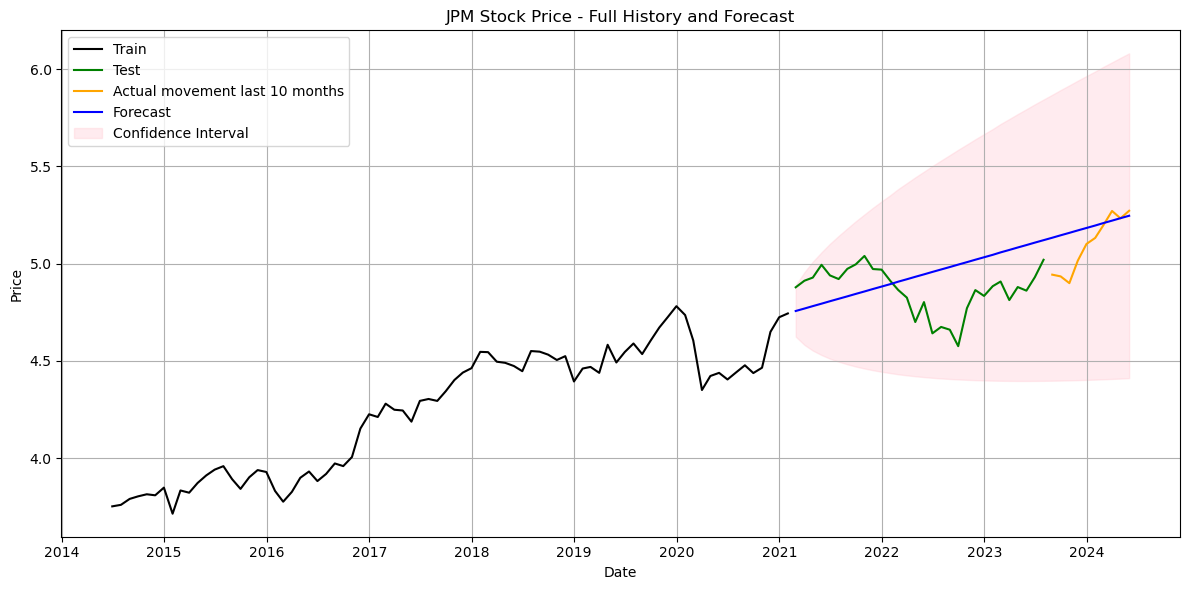

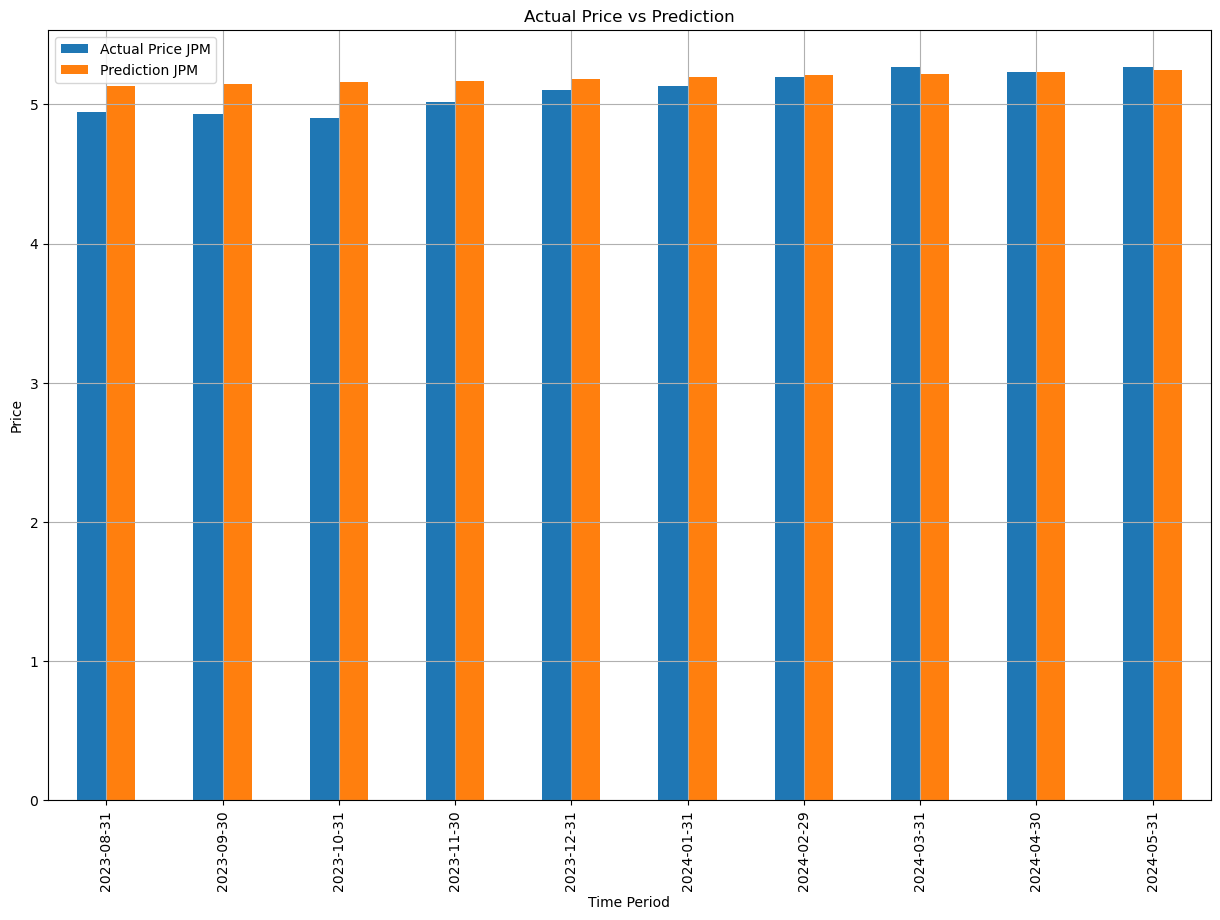

In [32]:
# ANALISI DI PREVISIONE JP MORGAN  

ticker = 'JPM'

data_to_train = data[ticker].resample("ME").last().dropna()
data_to_train = np.log(data_to_train)

n, m, l = 80, 30, 10

# Split training (80 mesi) and test (30 mesi)
train = data_to_train.iloc[:n]
test = data_to_train.iloc[n:m + n]  
actual = data_to_train.iloc[-l:]  # Ultimi 10 mesi per forecast

    
# Automatizing ARIMA model with best parameters 
model_auto = auto_arima(train, 
                   start_p=1, start_q=1,
                   max_p=3, max_q=3,
                   seasonal=False,
                   stepwise=True,
                   trace=True)
print(model_auto.summary())

# miglior parametri trovati per modello ARIMA su train set 
best_order = model_auto.order
print(f"Auto ARIMA found that the best order is {best_order}")


# effettuo previsione su 40 mesi, 30 test + 10 finali 
forecast, conf_int = model_auto.predict(n_periods=len(test) + 10, return_conf_int=True, alpha = 0.05)

# stampo a grafico andamento prezzo con previsione 
plot_forecast_vs_actual(train, test, forecast, actual, conf_int, ticker)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(actual, forecast[-10:])
print("MAE:", mae)

# Mean Squared Error (MSE)
mse = mean_squared_error(actual, forecast[-10:])
print("MSE:", mse)

# Root Mean Squared Error (RMSE)
rmse = root_mean_squared_error(actual, forecast[-10:]) 
print("RMSE:", rmse)


# Confronto prezzo attuale vs di previsione
compare_result(actual, forecast, ticker)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-163.344, Time=0.05 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-163.861, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-161.862, Time=0.01 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-161.862, Time=0.02 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-164.786, Time=0.01 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 0.087 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                   80
Model:               SARIMAX(0, 1, 0)   Log Likelihood                  83.393
Date:                Sun, 01 Jun 2025   AIC                           -164.786
Time:                        16:20:43   BIC                           -162.416
Sample:                    06-30-2014   HQIC                          -163.836
                         - 01-31-2021                                       

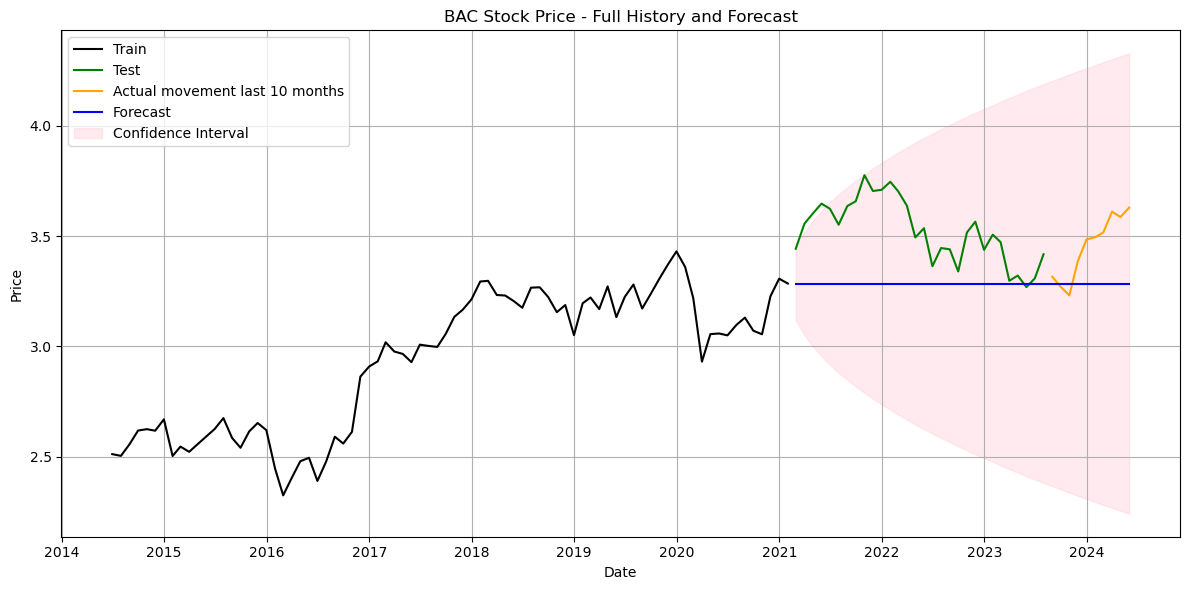

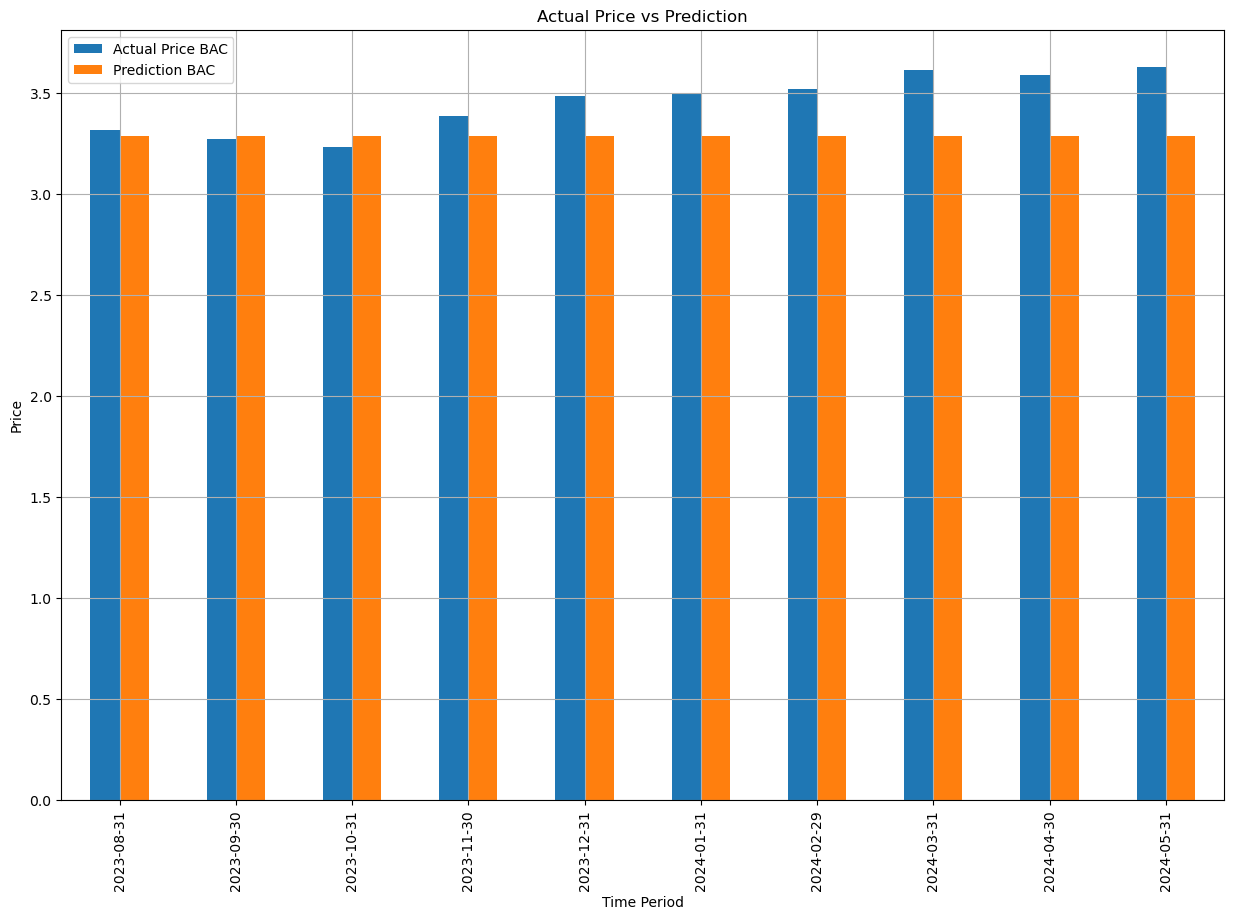

In [33]:
# ANALISI DI PREVISIONE BANK OF AMERICA  

ticker = 'BAC'

data_to_train = data[ticker].resample("ME").last().dropna()
data_to_train = np.log(data_to_train)

n, m, l = 80, 30, 10

# Split training (80 mesi) and test (30 mesi)
train = data_to_train.iloc[:n]
test = data_to_train.iloc[n:m + n]  
actual = data_to_train.iloc[-l:]  # Ultimi 10 mesi per forecast

    
# Automatizing ARIMA model with best parameters 
model_auto = auto_arima(train, 
                   start_p=1, start_q=1,
                   max_p=3, max_q=3,
                   seasonal=False,
                   stepwise=True,
                   trace=True)
print(model_auto.summary())

# miglior parametri trovati per modello ARIMA su train set 
best_order = model_auto.order
print(f"Auto ARIMA found that the best order is {best_order}")


# effettuo previsione su 40 mesi, 30 test + 10 finali 
forecast, conf_int = model_auto.predict(n_periods=len(test) + 10, return_conf_int=True, alpha = 0.05)

# stampo a grafico andamento prezzo con previsione 
plot_forecast_vs_actual(train, test, forecast, actual, conf_int, ticker)

# Mean Absolute Error (MAE)
mae = mean_absolute_error(actual, forecast[-10:])
print("MAE:", mae)

# Mean Squared Error (MSE)
mse = mean_squared_error(actual, forecast[-10:])
print("MSE:", mse)

# Root Mean Squared Error (RMSE)
rmse = root_mean_squared_error(actual, forecast[-10:]) 
print("RMSE:", rmse)


# Confronto prezzo attuale vs di previsione
compare_result(actual, forecast, ticker)

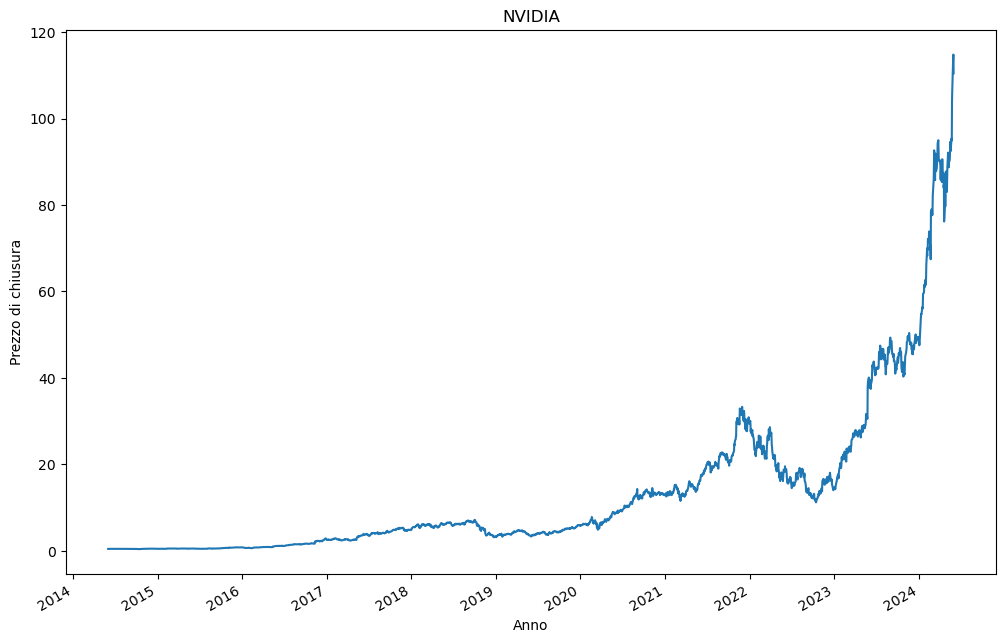

Date
2014-06-02      0.450631
2014-06-03      0.448728
2014-06-04      0.449204
2014-06-05      0.451107
2014-06-06      0.452773
                 ...    
2024-05-23    103.764908
2024-05-24    106.434029
2024-05-28    113.863579
2024-05-29    114.787277
2024-05-30    110.463692
Name: NVDA, Length: 2517, dtype: float64

In [34]:
# STRATEGIA SMA 200, 50 su stock NVIDIA 


# plot prezzi di chiusura nvidia (daily)
NVDA = data['NVDA']
NVDA.plot(figsize=(12, 8))
plt.title('NVIDIA')
plt.xlabel('Anno')
plt.ylabel('Prezzo di chiusura')
plt.show()

NVDA

In [35]:
# Calculate the 50 and 200 days moving averages of the closing prices
short_SMA_NVDA = NVDA.rolling(window=50, min_periods=1).mean()
long_SMA_NVDA = NVDA.rolling(window=200, min_periods=1).mean()



In [36]:
# create signal and position, rate of return, total return 

NVDA = pd.DataFrame({'Close': data['NVDA'], '50_SMA':short_SMA_NVDA, '200_SMA':long_SMA_NVDA})

# signals 
NVDA['Signal'] = np.where(NVDA['50_SMA']> NVDA['200_SMA'], 1, 0)

# generate trading orders
NVDA['Position'] = NVDA['Signal'].diff()

# calculate trading
NVDA['Trade'] = np.where(NVDA['50_SMA'] > NVDA['200_SMA'], 1, -1)

# calculate instant rate of return (daily log return) 
NVDA['Return'] = np.log(NVDA.Close).diff()

# calculate total trading return 
NVDA['Total_Return'] = NVDA.Return * NVDA.Trade

NVDA.head(100)

,Close,50_SMA,200_SMA,Signal,Position,Trade,Return,Total_Return
Date,,,,,,,,
2014-06-02,0.450631,0.450631,0.450631,0,NaN,-1,NaN,NaN
2014-06-03,0.448728,0.449680,0.449680,0,0.0,-1,-0.004233,0.004233
2014-06-04,0.449204,0.449521,0.449521,0,0.0,-1,0.001060,-0.001060
2014-06-05,0.451107,0.449918,0.449918,0,0.0,-1,0.004228,-0.004228
2014-06-06,0.452773,0.450489,0.450489,0,0.0,-1,0.003685,-0.003685
...,...,...,...,...,...,...,...,...
2014-10-15,0.416778,0.448729,0.447011,1,0.0,1,0.015021,0.015021
2014-10-16,0.417017,0.448676,0.446702,1,0.0,1,0.000573,0.000573
2014-10-17,0.416300,0.448693,0.446392,1,0.0,1,-0.001720,-0.001720


In [37]:
# Analyzing portoflio returns 

 # Calculating the short-window moving average for entire portfolio
short_rolling= data['NVDA'].rolling(window=50,min_periods=1).mean()
df_short = short_rolling.rename('NVDA_short')
# Calculating the long-window moving average for entire portfolio
long_rolling = data['NVDA'].rolling(window=200,min_periods=1).mean()
df_long = long_rolling.rename('NVDA_long')
#to join two tables into one df 
new_df=pd.concat([df_short,df_long],axis=1)

# calculate trading 
new_df['NVDA_Trade'] = np.where(new_df['NVDA_short'] > new_df['NVDA_long'], 1, -1)

# return column 
log_returns = np.log(data['NVDA']).diff()
df_return = log_returns.rename('NVDA_Return')
new_df = pd.concat([df_return, new_df], axis=1)

# clear nan values 
new_df.dropna(inplace=True)

# istantenius rate of return  (total return)
new_df['NVDA_Treturn']= new_df.NVDA_Return*new_df.NVDA_Trade
NVDA_total_treturn=np.exp(new_df.NVDA_Treturn.sum())
print('NVDA_total_treturn is:', NVDA_total_treturn)





NVDA_total_treturn is: 302.83317200900296


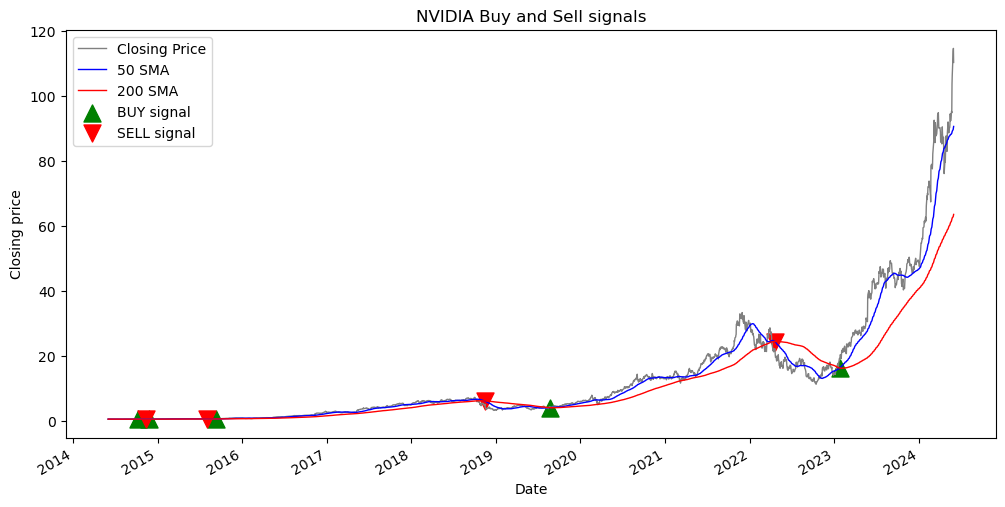

In [38]:
# Plot moving averages 
# plot closing price, short term moving averages and long term moving averages 
plt.figure(figsize=(12,6))
NVDA['Close'].plot(color = 'gray', label= 'Closing Price', linewidth = 1)
NVDA['50_SMA'].plot(color = 'blue',label = '50 SMA', linewidth = 1)
NVDA['200_SMA'].plot(color = 'red', label = '200 SMA', linewidth = 1)
# plot ‘buy’ signals
plt.scatter(NVDA.loc[NVDA['Position'] == 1].index, 
         NVDA['50_SMA'][NVDA['Position'] == 1], 
         marker='^', s=150,color = 'green', label = 'BUY signal')
# plot ‘sell’ signals
plt.scatter(NVDA.loc[NVDA['Position'] == -1].index, 
         NVDA['50_SMA'][NVDA['Position'] == -1], 
         marker='v',s=150, color = 'red', label = 'SELL signal')
plt.title('NVIDIA Buy and Sell signals')
plt.xlabel('Date')
plt.ylabel('Closing price')
plt.legend();

In [39]:
# confronto strategie 

# SMA Strategy return
total_treturn=np.exp(NVDA.Total_Return.sum())#total return of moving averages trading system
#Buy and hold return 
hold_return=np.exp(NVDA.Return.sum())#total return of buy and hold strategy
print("NVIDIA Trading System total return: {:>10.2%}".format(total_treturn))
print("NVIDIA Hold strategy return: {:>10.2%}".format(hold_return))

NVIDIA Trading System total return:  30283.32%
NVIDIA Hold strategy return:  24513.10%


Text(0.5, 1.0, 'NVIDIA SMA Strategy Performance')

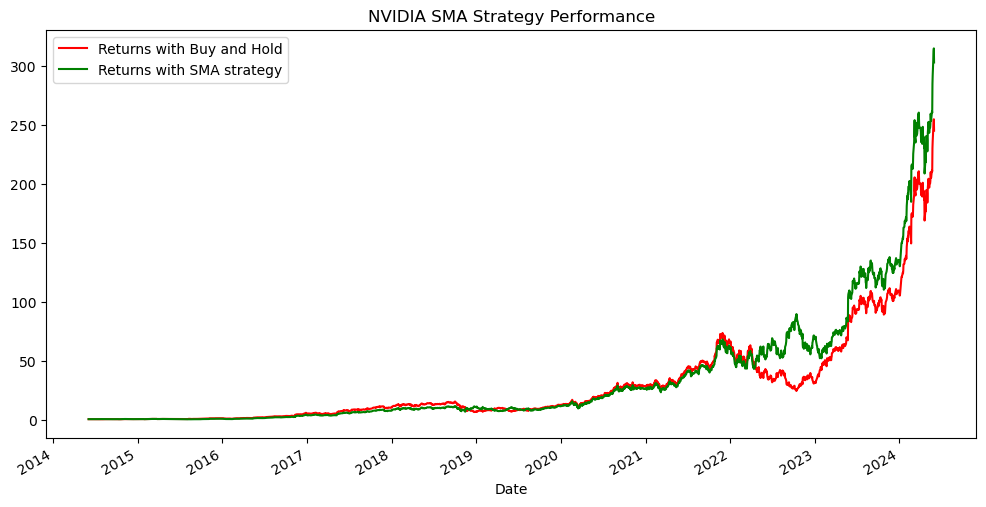

In [40]:
# Plot performance strategia con comparazione buy&hold

plt.figure(figsize=(12,6))
NVDA['Return'].cumsum().apply(np.exp).plot(color = 'red', label= 'Returns with Buy and Hold')
NVDA['Total_Return'].cumsum().apply(np.exp).plot(color = 'green',label = 'Returns with SMA strategy')
plt.legend()
plt.title('NVIDIA SMA Strategy Performance')

In [41]:
# Expected return with risk using SMA strategy

returns = log_returns #using log_return
print("Return: ", returns.mean()) # return
print("Risk: ", returns.std()) # measurement of risk

Return:  0.002186722004789269
Risk:  0.029571522109603874


In [42]:
# STRATEGIE DINAMICHE CPPI TIPP


# funzione per plottare comparazione buy&hold con cppi e floor price
def plot_cppi_performance(risky_returns, cppi, floor):
    chart = cppi.plot(figsize=(16,9), color="blue", legend=True)
    risky_returns.plot(ax=chart, style='g--', legend=True, linewidth = 1)
    floor_values.plot(ax=chart, style='red', legend=True)
    chart.legend(['With CPPI','Without CPPI','Floor'])


# calcolo strategia cppi
def cppi(returns, cppi=100, floor_percent=0.8, m=3, safe_asset_rate=0.04, update_floor=True):
    safe_assets = pd.DataFrame().reindex_like(returns)
    safe_assets[:] = safe_asset_rate / 255

    #Initial portfolio value
    CPPI = cppi
    # This is the minimum value I want to preserve (the floor price)
    F = CPPI * floor_percent
    max_cppi = cppi
        
    CPPI_values = pd.DataFrame().reindex_like(returns)
    floor_values = pd.DataFrame().reindex_like(returns)
    floor_values[:] = F
    for i in range(len(returns.index)):
        C = (CPPI - F)
        risky_asset_e = np.minimum(m* C, CPPI)
        risky_asset_e = np.maximum(risky_asset_e, 0)
        risklet_asset = CPPI - risky_asset_e 
        CPPI = risky_asset_e * (1 + returns.iloc[i]) + risklet_asset * (1 + safe_assets.iloc[i])
        CPPI_values.iloc[i] = CPPI
    return CPPI_values, floor_values


# Strategia di trading TIPP 
def tipp(returns, cppi=100, floor_percent=0.7, m=3, safe_asset_rate=0.04, gap = 1):
    safe_assets = pd.DataFrame().reindex_like(returns)
    safe_assets[:] = safe_asset_rate / 255
        
    #Initial portfolio value
    CPPI = cppi
    # This is the minimum value I want to preserve
    F = CPPI * floor_percent
    max_cppi = cppi
        
    CPPI_values = pd.DataFrame().reindex_like(returns)
    floor_values = pd.DataFrame().reindex_like(returns)
    floor_values[:] = F
    for i in range(len(returns.index)):
        F_updated = CPPI * floor_percent
        F = np.maximum(F, F_updated) 
        if i % gap != 0 and i != 0:
            CPPI = risky_asset_e * (1 + returns.iloc[i].item()) + risklet_asset * (1 + safe_assets.iloc[i].item())
            CPPI_values.iloc[i] = CPPI
            continue  
        C = (CPPI - F)
        risky_asset_e = np.minimum(m* C, CPPI)
        risky_asset_e = np.maximum(risky_asset_e, 0)
        risklet_asset = CPPI - risky_asset_e 
        CPPI = risky_asset_e * (1 + returns.iloc[i].item()) + risklet_asset * (1 + safe_assets.iloc[i].item())
        CPPI_values.iloc[i] = CPPI
        floor_values.iloc[i] = F.item()
    return CPPI_values, floor_values



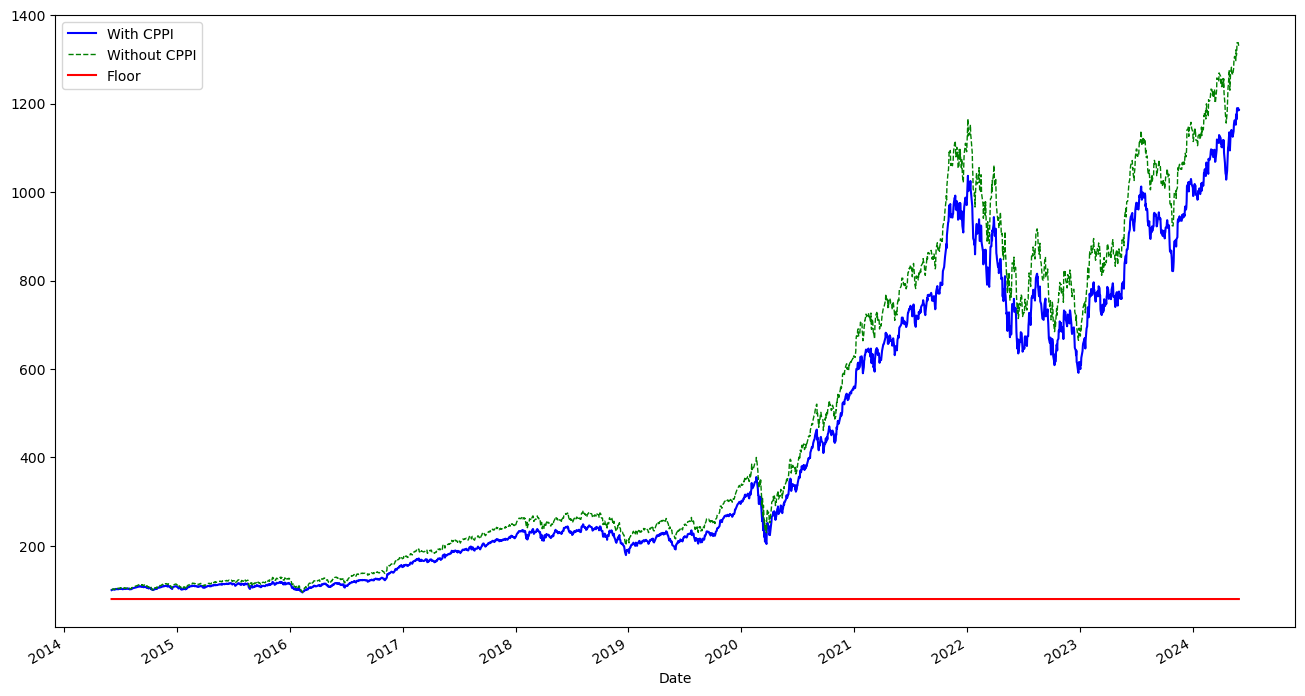

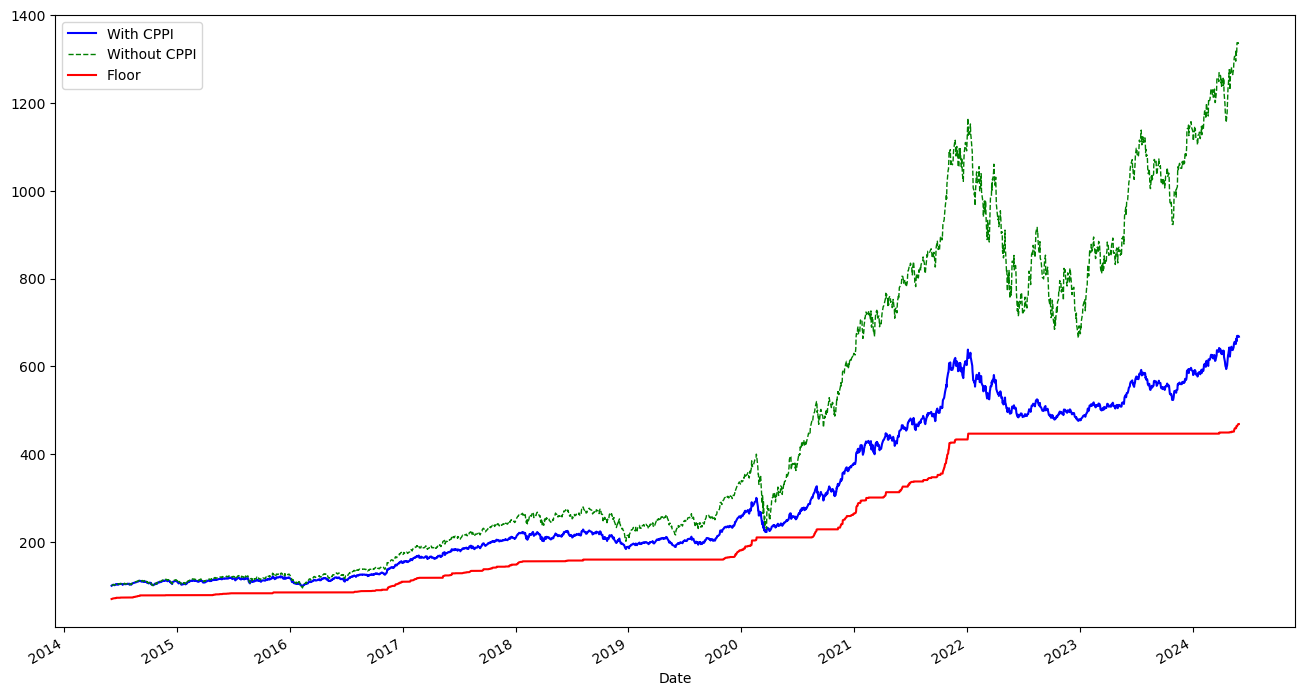

In [43]:
# CPPI su portafolio 
stock_returns = r_netti
stock_returns = stock_returns.multiply(1/len(tickers), axis=1).sum(1).to_frame()
normal = 100 * (1 + stock_returns).cumprod()
cppi_values, floor_values = cppi(stock_returns)
plot_cppi_performance(normal, cppi_values, floor_values)
cppi_values, floor_values = tipp(stock_returns)
plot_cppi_performance(normal, cppi_values, floor_values)



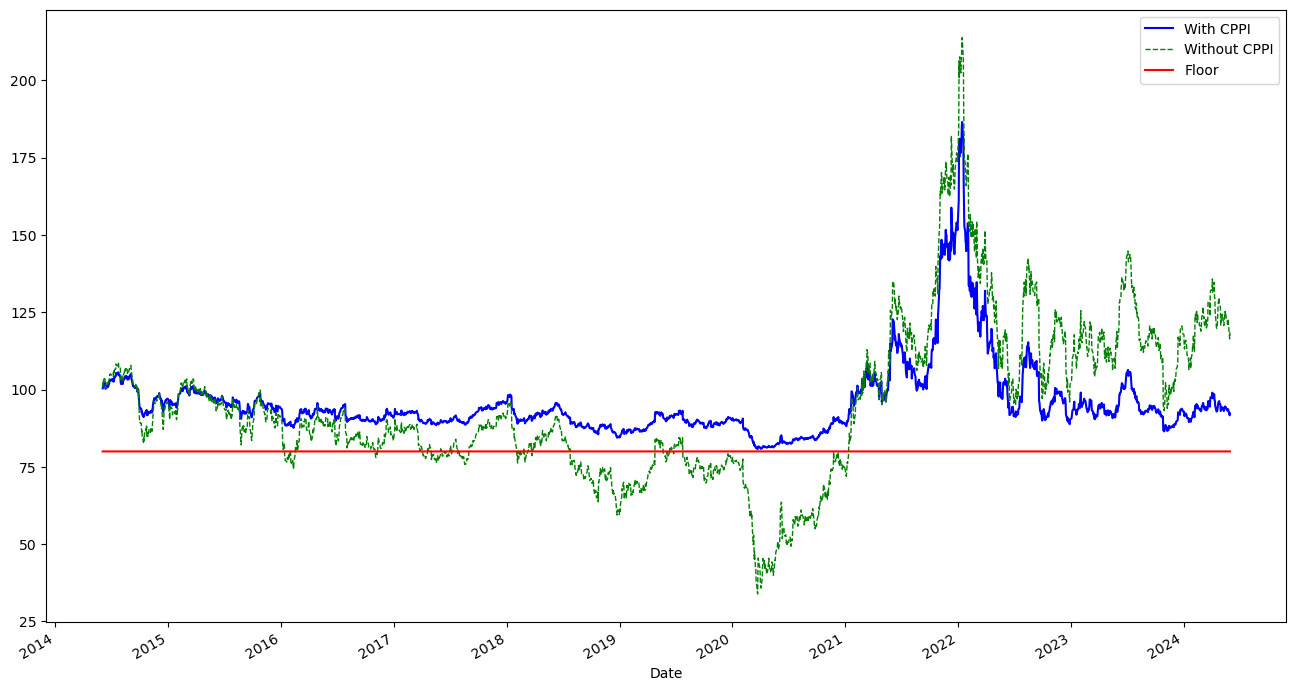

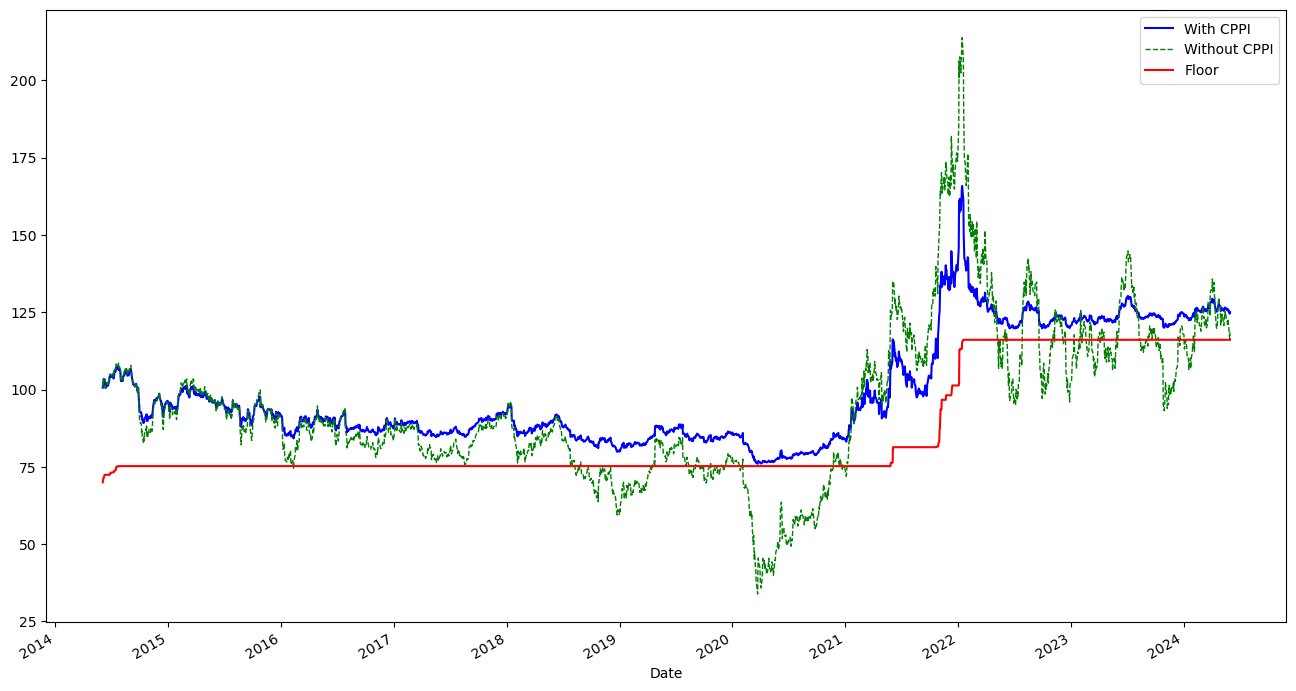

In [44]:
### CPPI su singolo asset con maggior downside dopo l'acquisto iniziale nel 2014 (FORD)

single_returns = r_netti['F_R_NETTI'].to_frame()
normal = 100 * (1 + single_returns).cumprod()
cppi_values, floor_values = cppi(single_returns)
plot_cppi_performance(normal, cppi_values, floor_values)
cppi_values, floor_values = tipp(single_returns)
plot_cppi_performance(normal, cppi_values, floor_values)



In [45]:
# CAPM 

# SP500 indice mercato 
market_benchmark = '^GSPC' # S&P 500
sp500_df = yf.download(market_benchmark,
                       start = start, end = end)['Close']

market_data = sp500_df.resample('ME').last().pct_change().dropna() # trasformo in ritorni mensili

market_data

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Ticker,^GSPC
Date,
2014-07-31,-0.015080
2014-08-31,0.037655
2014-09-30,-0.015514
2014-10-31,0.023201
2014-11-30,0.024534
...,...
2024-01-31,0.015896
2024-02-29,0.051721
2024-03-31,0.031019


In [46]:
# Calcolo beta rispetto all'indice di mercato 
betas = {}
for ticker in tickers:
    stock_data = data[ticker].resample('ME').last().pct_change().dropna()

    X = pd.DataFrame()

    X['BAC'] = stock_data

    X['MARKET'] = market_data

    covariance = X.cov().iloc[0,1]
    benchmark_variance = X.MARKET.var()
    beta = covariance / benchmark_variance
    betas[ticker] = beta
    print(f"Indice beta per {ticker}: " + str(beta))
    
    

Indice beta per NVDA: 1.805786898348092
Indice beta per AAPL: 1.2379343960815226
Indice beta per TSLA: 1.8275492832883087
Indice beta per F: 1.477183965385091
Indice beta per JPM: 1.1380744112968757
Indice beta per BAC: 1.4048543672839477


In [47]:
# stima rendimenti risk free usando T-Bill


#FRED API key 
api_key = 'ee74ad7d5b4ec65ef98907efa5cbb33c' 

# Series ID for 1-Year Treasury Bill Rate (Secondary Market)
series_id = 'RIFSGFSY01NA'

start_date = '2023-01-01'
end_date = '2024-01-01'


# Construct the FRED API URL
url = f'https://api.stlouisfed.org/fred/series/observations?series_id={series_id}&api_key={api_key}&file_type=json&observation_start={start_date}&observation_end={end_date}'

# Make the request
response = requests.get(url)
data_rf = response.json()

# Extract the most recent value
r_f = data_rf['observations'][0]['value']
r_f = float(r_f) / 100 # divido per 100 in quanto mi ritorna una percentuale 
r_f

0.0484

In [48]:
# annualized return sp500
sp500 = sp500_df.pct_change().dropna()
# Calcolo il rendimento annualizzato dell'S&P 500 (stima del mercato)
r_m = ((1 + sp500['^GSPC'].mean()) ** 252) - 1
r_m

0.12299429408195972

In [49]:
# calcolo rendimenti attesi titoli 

ER = {}

for ticker in tickers: 
    ER[ticker] = r_f + betas[ticker] * (r_m - r_f) # formula per calcolo rendimento atteso

ER

{'NVDA': 0.1831013989447275,
 'AAPL': 0.1407428423954783,
 'TSLA': 0.18472474868688282,
 'F': 0.15858949512709086,
 'JPM': 0.13329385732343232,
 'BAC': 0.15319411981550424}

In [50]:
# fama french 

# Get the Fama French 3 factor model (monthly data)
ff_factors_monthly = gff.famaFrench3Factor(frequency='m') 


ff_factors_monthly.set_index('date_ff_factors', inplace=True)


ff_factors_monthly.index.names = ["Date"]


ff_factors_monthly


,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07-31,0.0289,-0.0255,-0.0239,0.0022
1926-08-31,0.0264,-0.0114,0.0381,0.0025
1926-09-30,0.0038,-0.0136,0.0005,0.0023
1926-10-31,-0.0327,-0.0014,0.0082,0.0032
1926-11-30,0.0254,-0.0011,-0.0061,0.0031
...,...,...,...,...
2024-11-30,0.0649,0.0446,0.0016,0.0040
2024-12-31,-0.0317,-0.0271,-0.0299,0.0037
2025-01-31,0.0280,-0.0197,0.0163,0.0037


In [51]:
def fama_french_model(ticker):
    asset_returns = data[ticker].resample('ME').last().pct_change().dropna()
    # Filter factor dates to match the asset
    ff_factors_subset = ff_factors_monthly[
        ff_factors_monthly.index.isin(asset_returns.index)
    ].copy()
    
    # Calculate excess returns for the asset
    ff_factors_subset["Excess_Return"] = asset_returns - ff_factors_subset["RF"]
    # Prepare the independent variables (add a constant to the model)
    X = sm.add_constant(ff_factors_subset[["Mkt-RF", "SMB", "HML"]])
    # The dependent variable (excess returns of the stock)
    y = ff_factors_subset["Excess_Return"]
    # Run the regression
    model = sm.OLS(y, X).fit()
    # Display the summary of the regression
    print(model.summary())

In [52]:
# NVIDIA 
fama_french_model('NVDA')

                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.418
Model:                            OLS   Adj. R-squared:                  0.403
Method:                 Least Squares   F-statistic:                     27.54
Date:                Sun, 01 Jun 2025   Prob (F-statistic):           1.70e-13
Time:                        16:20:47   Log-Likelihood:                 101.65
No. Observations:                 119   AIC:                            -195.3
Df Residuals:                     115   BIC:                            -184.2
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0363      0.010      3.664      0.0

In [53]:
# APPLE 
fama_french_model('AAPL')

                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.535
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     44.10
Date:                Sun, 01 Jun 2025   Prob (F-statistic):           4.80e-19
Time:                        16:20:47   Log-Likelihood:                 176.80
No. Observations:                 119   AIC:                            -345.6
Df Residuals:                     115   BIC:                            -334.5
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0077      0.005      1.457      0.1

In [54]:
# TESLA
fama_french_model('TSLA')

                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.293
Model:                            OLS   Adj. R-squared:                  0.274
Method:                 Least Squares   F-statistic:                     15.88
Date:                Sun, 01 Jun 2025   Prob (F-statistic):           1.05e-08
Time:                        16:20:47   Log-Likelihood:                 57.851
No. Observations:                 119   AIC:                            -107.7
Df Residuals:                     115   BIC:                            -96.59
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0158      0.014      1.103      0.2

In [55]:
# FORD
fama_french_model('F')

                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.465
Method:                 Least Squares   F-statistic:                     35.25
Date:                Sun, 01 Jun 2025   Prob (F-statistic):           3.13e-16
Time:                        16:20:47   Log-Likelihood:                 140.70
No. Observations:                 119   AIC:                            -273.4
Df Residuals:                     115   BIC:                            -262.3
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0057      0.007     -0.798      0.4

In [56]:
# BANK OF AMERICA
fama_french_model('BAC')

                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     122.6
Date:                Sun, 01 Jun 2025   Prob (F-statistic):           1.14e-35
Time:                        16:20:47   Log-Likelihood:                 209.91
No. Observations:                 119   AIC:                            -411.8
Df Residuals:                     115   BIC:                            -400.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0013      0.004      0.330      0.7

In [57]:
# JP MORGAN 
fama_french_model('JPM')

                            OLS Regression Results                            
Dep. Variable:          Excess_Return   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.741
Method:                 Least Squares   F-statistic:                     113.6
Date:                Sun, 01 Jun 2025   Prob (F-statistic):           3.04e-34
Time:                        16:20:47   Log-Likelihood:                 230.39
No. Observations:                 119   AIC:                            -452.8
Df Residuals:                     115   BIC:                            -441.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0055      0.003      1.644      0.1